<a href="https://colab.research.google.com/github/sansen405/AI-Object-Detection/blob/main/AI_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Download data and prepare environment { display-mode: "form" }

import matplotlib.pyplot as plt
import os
from PIL import Image
import gdown

import argparse
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers import concatenate, add
from keras.models import Model
import struct
import cv2
from copy import deepcopy

# Prepare data
DATA_ROOT = '/content/data'
os.makedirs(DATA_ROOT, exist_ok=True)

# image_url = 'https://drive.google.com/uc?id=12ZpZ5H0kJIkWk6y4ktGfqR5OTKofL7qw'
# image_path = os.path.join(DATA_ROOT, 'image.jpg')
# gdown.download(image_url, image_path, True)
!wget -O /content/data/image.jpg "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image.jpg"

# image2_url = 'https://drive.google.com/uc?id=1_WpFbGEuS2r19UeP6wekbcF0kb-0nH18'
# image2_path = os.path.join(DATA_ROOT, 'image2.jpg')
# gdown.download(image2_url, image2_path, True)
!wget -O /content/data/image2.jpg "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image2.jpg"

# video_url = 'https://drive.google.com/uc?id=1xFGjpzhZVYtNor9hJevvxysGESZJIMDz'
# video_path = os.path.join(DATA_ROOT, 'video1.mp4')
# gdown.download(video_url, video_path, True)
!wget -O /content/data/video1.mp4 "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/6.mp4"

# model_url = 'https://drive.google.com/uc?id=19XKJWMKDfDlag2MR8ofjwvxhtr9BxqqN'
model_path = os.path.join(DATA_ROOT, 'yolo_weights.h5')
# gdown.download(model_url, model_path, True)
!wget -O /content/data/yolo_weights.h5 "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/yolo.h5"

labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", \
              "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", \
              "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", \
              "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", \
              "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", \
              "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", \
              "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", \
              "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", \
              "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", \
              "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax

        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])

    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

    union = w1*h1 + w2*h2 - intersect

    return float(intersect) / union

def preprocess_input(image_pil, net_h, net_w):
    image = np.asarray(image_pil)
    new_h, new_w, _ = image.shape

    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)/new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)/new_h
        new_h = net_h

    # resize the image to the new size
    #resized = cv2.resize(image[:,:,::-1]/255., (int(new_w), int(new_h)))
    resized = cv2.resize(image/255., (int(new_w), int(new_h)))

    # embed the image into the standard letter box
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[int((net_h-new_h)//2):int((net_h+new_h)//2), int((net_w-new_w)//2):int((net_w+new_w)//2), :] = resized
    new_image = np.expand_dims(new_image, 0)

    return new_image


def decode_netout(netout_, obj_thresh, anchors_, image_h, image_w, net_h, net_w):
    netout_all = deepcopy(netout_)
    boxes_all = []
    for i in range(len(netout_all)):
      netout = netout_all[i][0]
      anchors = anchors_[i]

      grid_h, grid_w = netout.shape[:2]
      nb_box = 3
      netout = netout.reshape((grid_h, grid_w, nb_box, -1))
      nb_class = netout.shape[-1] - 5

      boxes = []

      netout[..., :2]  = _sigmoid(netout[..., :2])
      netout[..., 4:]  = _sigmoid(netout[..., 4:])
      netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
      netout[..., 5:] *= netout[..., 5:] > obj_thresh

      for i in range(grid_h*grid_w):
          row = i // grid_w
          col = i % grid_w

          for b in range(nb_box):
              # 4th element is objectness score
              objectness = netout[row][col][b][4]
              #objectness = netout[..., :4]
              # last elements are class probabilities
              classes = netout[row][col][b][5:]

              if((classes <= obj_thresh).all()): continue

              # first 4 elements are x, y, w, and h
              x, y, w, h = netout[row][col][b][:4]

              x = (col + x) / grid_w # center position, unit: image width
              y = (row + y) / grid_h # center position, unit: image height
              w = anchors[b][0] * np.exp(w) / net_w # unit: image width
              h = anchors[b][1] * np.exp(h) / net_h # unit: image height

              box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
              #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

              boxes.append(box)

      boxes_all += boxes

    # Correct boxes
    boxes_all = correct_yolo_boxes(boxes_all, image_h, image_w, net_h, net_w)

    return boxes_all

def correct_yolo_boxes(boxes_, image_h, image_w, net_h, net_w):
    boxes = deepcopy(boxes_)
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h

    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h

        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
    return boxes

def do_nms(boxes_, nms_thresh, obj_thresh):
    boxes = deepcopy(boxes_)
    if len(boxes) > 0:
        num_class = len(boxes[0].classes)
    else:
        return

    for c in range(num_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

    new_boxes = []
    for box in boxes:
        label = -1

        for i in range(num_class):
            if box.classes[i] > obj_thresh:
                label = i
                # print("{}: {}, ({}, {})".format(labels[i], box.classes[i]*100, box.xmin, box.ymin))
                box.label = label
                box.score = box.classes[i]
                new_boxes.append(box)

    return new_boxes


from PIL import ImageDraw, ImageFont
import colorsys

def draw_boxes(image_, boxes, labels):
    image = image_.copy()
    image_w, image_h = image.size
    font = ImageFont.truetype(font='/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf',
                    size=np.floor(3e-2 * image_h + 0.5).astype('int32'))
    thickness = (image_w + image_h) // 300

    # Generate colors for drawing bounding boxes.
    hsv_tuples = [(x / len(labels), 1., 1.)
                  for x in range(len(labels))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(
        map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    np.random.seed(10101)  # Fixed seed for consistent colors across runs.
    np.random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    np.random.seed(None)  # Reset seed to default.

    for i, box in reversed(list(enumerate(boxes))):
        c = box.get_label()
        predicted_class = labels[c]
        score = box.get_score()
        top, left, bottom, right = box.ymin, box.xmin, box.ymax, box.xmax

        label = '{} {:.2f}'.format(predicted_class, score)
        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)
        #label_size = draw.textsize(label)

        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image_h, np.floor(bottom + 0.5).astype('int32'))
        right = min(image_w, np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i],
                outline=colors[c])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        #draw.text(text_origin, label, fill=(0, 0, 0))
        del draw
    return image

--2023-10-22 23:49:55--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.207, 172.253.119.207, 108.177.121.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94721 (93K) [image/jpeg]
Saving to: ‘/content/data/image.jpg’

/content/data/image 100%[===================>]  92.50K  --.-KB/s    in 0.001s  

2023-10-22 23:49:56 (112 MB/s) - ‘/content/data/image.jpg’ saved [94721/94721]

--2023-10-22 23:49:56--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image2.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.207, 172.253.119.2

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
anchors = [[[116,90], [156,198], [373,326]], [[30,61], [62,45], [59,119]], [[10,13], [16,30], [33,23]]]


Example of Anchor Boxes
<img src="http://www.programmersought.com/images/401/891354390c3aab3f1ab1fd0db3110bf9.png" width="400"/>

The type of the saved image is <class 'PIL.JpegImagePlugin.JpegImageFile'>


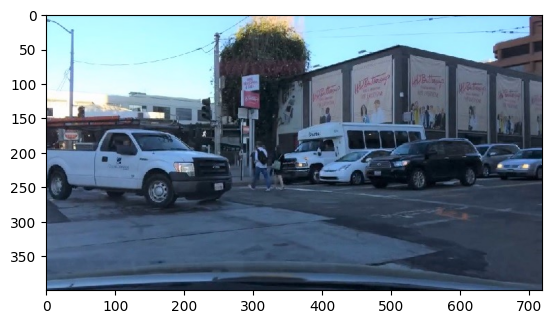

In [ ]:
from PIL import Image
from matplotlib import  pyplot as plt

image_path = '/content/data/image.jpg'

image_pil = Image.open(image_path)
image_w, image_h = image_pil.size
print("The type of the saved image is {}".format(type(image_pil)))
plt.imshow(image_pil)
plt.show()

Image Preprocessing

In [ ]:
net_h = 416
net_w = 416
new_image = preprocess_input(image_pil, net_h, net_w)

In [ ]:
plt.imshow(new_image[0])
plt.show()

DarkNet Architecture




<img src="https://miro.medium.com/max/2000/1*d4Eg17IVJ0L41e7CTWLLSg.png" width="1000"/>







In [ ]:
import tensorflow as tf

# Load model
darknet = tf.keras.models.load_model(model_path)

In [ ]:
yolo_outputs = darknet.predict(new_image)

len(yolo_outputs)

print(yolo_outputs[0].shape)
print(yolo_outputs[1].shape)
print(yolo_outputs[2].shape)



1/1 [==============================] - 9s 9s/step
(1, 13, 13, 255)
(1, 26, 26, 255)
(1, 52, 52, 255)


Post-processing for bounding box prediction

In [ ]:
obj_thresh = 0.4
nms_thresh = 0.45

car 1.00 (653, 189) (720, 243)
person 0.88 (325, 189) (348, 258)
person 0.93 (297, 185) (328, 253)
car 0.99 (625, 187) (688, 233)
traffic light 0.43 (224, 123) (239, 153)
car 0.98 (462, 180) (635, 256)
car 0.48 (375, 181) (534, 243)
bus 0.91 (353, 153) (555, 233)
truck 0.95 (0, 161) (268, 278)


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

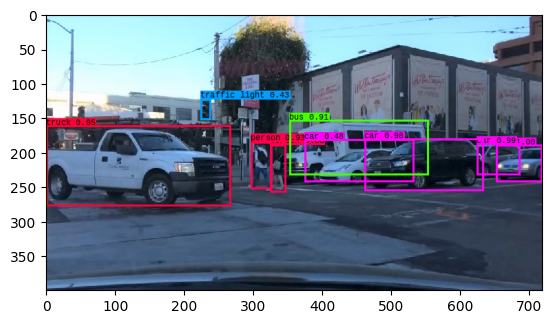

In [ ]:
boxes = decode_netout(yolo_outputs, obj_thresh, anchors, image_h, image_w, net_h, net_w)

boxes = do_nms(boxes, nms_thresh, obj_thresh)

image_detect = draw_boxes(image_pil, boxes, labels)
plt.imshow(image_detect)



Non-Maximal Suppression

person 0.51 (325, 203) (348, 256)
car 0.96 (666, 191) (720, 241)
car 1.00 (653, 189) (720, 243)
car 0.84 (623, 190) (685, 239)
person 0.88 (325, 189) (348, 258)
person 0.93 (297, 185) (328, 253)
car 0.90 (650, 187) (720, 237)
car 0.99 (625, 187) (688, 233)
car 0.69 (618, 189) (678, 233)
traffic light 0.43 (224, 123) (239, 153)
car 0.60 (632, 186) (720, 238)
car 0.46 (614, 185) (697, 234)
car 0.95 (478, 180) (634, 255)
car 0.98 (462, 180) (635, 256)
car 0.48 (375, 181) (534, 243)
person 0.46 (296, 184) (342, 258)
bus 0.91 (353, 153) (555, 233)
bus 0.47 (339, 156) (537, 232)
truck 0.85 (0, 173) (274, 285)
bus 0.82 (345, 144) (570, 237)
bus 0.43 (326, 146) (547, 239)
truck 0.95 (0, 161) (268, 278)


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

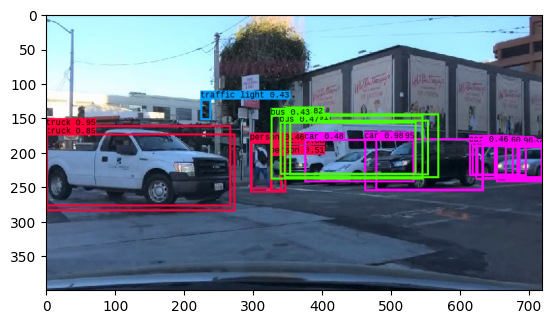

In [ ]:
boxes = decode_netout(yolo_outputs, obj_thresh, anchors, image_h, image_w, net_h, net_w)
image_detect = draw_boxes(image_pil, boxes, labels)
plt.imshow(image_detect)

Image Detection Function

In [ ]:
def detect_image(image_pil, obj_thresh = 0.4, nms_thresh = 0.45, darknet=darknet, net_h=416, net_w=416, anchors=anchors, labels=labels):
  new_image = preprocess_input(image_pil, net_h, net_w)
  yolo_outputs = darknet.predict(new_image)

  image_w, image_h = image_pil.size

  boxes = decode_netout(yolo_outputs, obj_thresh, anchors, image_h, image_w, net_h, net_w)

  boxes = do_nms(boxes, nms_thresh, obj_thresh)

  image_detect = draw_boxes(image_pil, boxes, labels)
  return image_detect


1/1 [==============================] - 0s 27ms/step
car 1.00 (653, 189) (720, 243)
person 0.88 (325, 189) (348, 258)
person 0.93 (297, 185) (328, 253)
car 0.99 (625, 187) (688, 233)
traffic light 0.43 (224, 123) (239, 153)
car 0.98 (462, 180) (635, 256)
car 0.48 (375, 181) (534, 243)
bus 0.91 (353, 153) (555, 233)
truck 0.95 (0, 161) (268, 278)


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

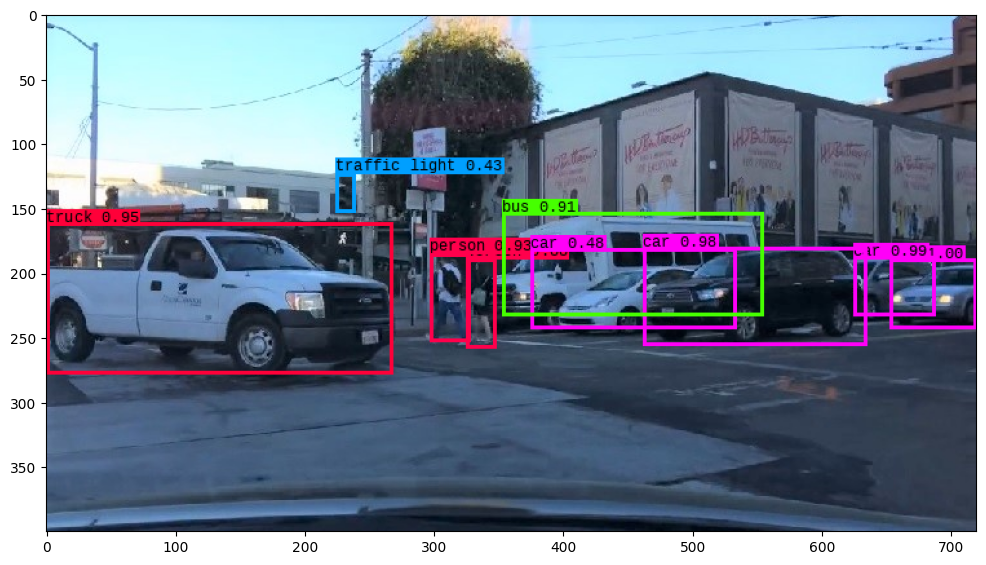

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(detect_image(image_pil))
plt.show()




Detection on Videos

In [ ]:
import cv2

def detect_video(video_path, output_path, obj_thresh = 0.4, nms_thresh = 0.45, darknet=darknet, net_h=416, net_w=416, anchors=anchors, labels=labels):
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video")
    video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
    video_FourCC = cv2.VideoWriter_fourcc(*'mp4v')
    video_fps       = vid.get(cv2.CAP_PROP_FPS)
    video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
                        int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))

    out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)

    num_frame = 0
    while vid.isOpened():
      ret, frame = vid.read()
      num_frame += 1
      print("=== Frame {} ===".format(num_frame))
      if ret:
          new_frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
          new_frame = detect_image(new_frame)

          new_frame = cv2.cvtColor(np.asarray(new_frame), cv2.COLOR_RGB2BGR)
          out.write(new_frame)
      else:
          break
    vid.release()
    out.release()
    print("New video saved!")

In [ ]:
video_path = '/content/data/video1.mp4'
output_path = '/content/data/video1_detected.mp4'
detect_video(video_path, output_path)

=== Frame 1 ===
1/1 [==============================] - 0s 48ms/step
car 0.98 (400, 381) (490, 443)
person 0.53 (851, 368) (885, 418)
car 0.72 (368, 378) (413, 407)
car 0.78 (589, 358) (619, 385)
car 0.94 (2, 377) (124, 527)
=== Frame 2 ===
1/1 [==============================] - 0s 48ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (401, 381) (490, 443)
person 0.57 (847, 361) (894, 425)
car 0.52 (747, 372) (802, 401)
car 0.81 (369, 378) (413, 407)
car 0.72 (589, 357) (620, 385)
car 0.97 (3, 374) (118, 530)
car 0.51 (0, 581) (1262, 720)
=== Frame 3 ===
1/1 [==============================] - 0s 48ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (403, 382) (487, 440)
person 0.54 (856, 367) (893, 418)
car 0.68 (747, 373) (807, 402)
car 0.89 (369, 379) (411, 406)
car 0.70 (590, 356) (621, 384)
car 0.98 (2, 372) (109, 531)
=== Frame 4 ===

<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te


1/1 [==============================] - 0s 54ms/step
car 0.98 (405, 384) (485, 439)
car 0.60 (749, 373) (810, 402)
car 0.91 (369, 379) (410, 406)
car 0.67 (589, 356) (624, 385)
car 0.95 (1, 369) (88, 532)
=== Frame 5 ===
1/1 [==============================] - 0s 43ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (405, 384) (487, 439)
person 0.42 (853, 365) (905, 424)
car 0.70 (748, 372) (815, 405)
car 0.92 (369, 380) (409, 406)
person 0.41 (693, 361) (710, 401)
car 0.41 (609, 362) (635, 386)
car 0.61 (590, 356) (623, 384)
car 0.96 (2, 364) (80, 534)


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

=== Frame 6 ===
1/1 [==============================] - 0s 98ms/step
car 0.98 (410, 388) (485, 437)
car 0.70 (747, 374) (815, 404)
car 0.92 (369, 379) (410, 407)
car 0.68 (608, 362) (636, 388)
car 0.65 (590, 355) (626, 384)
car 0.96 (2, 370) (69, 531)
=== Frame 7 ===
1/1 [==============================] - 0s 52ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.94 (0, 396) (58, 541)
car 0.99 (410, 385) (488, 438)
person 0.55 (869, 358) (912, 425)
car 0.56 (746, 373) (818, 405)
car 0.92 (369, 381) (409, 407)
person 0.40 (692, 363) (707, 397)
car 0.58 (608, 360) (637, 385)
car 0.50 (591, 354) (627, 383)


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

=== Frame 8 ===
1/1 [==============================] - 0s 90ms/step
car 0.73

<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

 (0, 409) (41, 536)
car 0.98 (411, 386) (490, 438)
person 0.49 (867, 360) (914, 424)
car 0.48 (766, 373) (820, 403)
car 0.40 (422, 381) (485, 411)
car 0.93 (369, 380) (409, 407)
car 0.72 (609, 362) (638, 387)
car 0.49 (592, 354) (627, 382)
=== Frame 9 ===
1/1 [==============================] - 0s 44ms/step
car 0.61 (1, 408) (30, 535)
car 0.98 (410, 388) (492, 438)
person 0.67 (868, 360) (920, 427)
car 0.53 (761, 372) (824, 405)
car 0.44 (421, 381) (488, 411)
car 0.93 (366, 381) (409, 408)
car 0.66 (608, 360) (639, 387)
=== Frame 10 ===
1/1 [==============================] - 0s 42ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (415, 385) (491, 439)
person 0.76 (869, 357) (920, 429)
person 0.41 (696, 367) (711, 407)
car 0.92 (368, 381) (409, 408)
person 0.41 (719, 357) (736, 403)
car 0.78 (612, 361) (640, 387)
car 0.43 (592, 353) (624, 380)
traffic light 0.41 (666, 314) (680, 334)


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

=== Frame 11 ===
1/1 [==============================] - 0s 121ms/step
person 0.84 (873, 359) (923, 430)
car 0.55 (767, 373) (827, 402)
car 0.96 (418, 379) (499, 428)
car 0.97 (365, 379) (408, 409)
car 0.73 (612, 361) (640, 386)
traffic light 0.49 (665, 312) (681, 334)
car 0.52 (32, 602) (1205, 720)
=== Frame 12 ===
1/1 [==============================] - 0s 42ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (417, 385) (497, 440)
car 0.47 (853, 364) (941, 420)
person 0.77 (873, 358) (925, 430)
car 0.82 (765, 373) (835, 402)
person 0.42 (698, 367) (714, 407)
car 0.40 (426, 380) (493, 410)
car 0.99 (363, 380) (407, 410)
car 0.83 (611, 361) (641, 388)
traffic light 0.40 (666, 310) (682, 332)
=== Frame 13 ===
1/1 [==============================] - 0s 63ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.96 (418, 385) (495, 438)
person 0.41 (895, 358) (937, 431)
car 0.51 (858, 368) (944, 418)
car 0.81 (767, 373) (837, 402)
car 0.57 (424, 380) (495, 412)
car 0.98 (363, 381) (407, 411)
car 0.75 (608, 358) (640, 388)
traffic light 0.46 (667, 310) (683, 334)
=== Frame 14 ===
1/1 [==============================] - 0s 54ms/step
car 0.97 (419, 388) (497, 439)
person 0.70 (898, 356) (943, 433)
car 0.70 (767, 371) (844, 403)
car 0.78 (423, 381) (497, 412)
car 0.97 (363, 383) (405, 411)
car 0.89 (606, 358) (641, 388)
traffic light 0.49 (667, 310) (684, 335)
=== Frame 15 ===
1/1 [==============================] - ETA: 0s

<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

1/1 [==============================] - 0s 83ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.66 (900, 356) (947, 436)
car 0.75 (768, 372) (844, 403)
car 0.96 (425, 379) (500, 428)
car 0.98 (364, 382) (406, 411)
car 0.88 (608, 358) (642, 388)
=== Frame 16 ===
1/1 [==============================] - 0s 60ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.94 (424, 388) (499, 437)
person 0.76 (903, 357) (950, 435)
car 0.62 (764, 373) (848, 405)
car 0.52 (428, 380) (496, 412)
car 0.98 (359, 383) (405, 412)
car 0.43 (0, 372) (58, 420)
car 0.86 (609, 357) (643, 388)
traffic light 0.43 (667, 308) (682, 333)
=== Frame 17 ===
1/1 [==============================] - 0s 81ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.96 (426, 387) (502, 438)
car 0.66 (872, 365) (964, 425)
person 0.53 (899, 360) (954, 433)
car 0.63 (762, 371) (848, 406)
car 0.98 (358, 381) (405, 413)
car 0.67 (608, 356) (641, 387)
traffic light 0.50 (670, 311) (684, 332)
=== Frame 18 ===
1/1 [==============================] - 0s 100ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (426, 389) (504, 440)
person 0.45 (923, 360) (964, 438)
car 0.65 (868, 368) (968, 420)
car 0.67 (782, 373) (853, 403)
car 0.52 (440, 384) (503, 415)
car 0.99 (358, 382) (403, 413)
car 0.45 (0, 373) (56, 422)
car 0.53 (610, 356) (644, 388)
=== Frame 19 ===
1/1 [==============================] - 0s 87ms/step
car 0.94 (433, 388) (506, 438)
person 0.83 (923, 360) (964, 441)
car 0.44 (867, 368) (970, 421)
car 0.74 (782, 371) (852, 404)
car 0.59 (441, 383) (505, 413)
car 0.98 (359, 383) (403, 414)
car 0.41 (0, 373) (58, 422)
car 0.54 (611, 356) (643, 386)
=== Frame 20 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (435, 387) (505, 439)
person 0.94 (926, 357) (971, 439)
car 0.63 (785, 374) (852, 403)
car 0.51 (443, 382) (502, 412)
car 0.98 (356, 383) (401, 416)
car 0.47 (612, 355) (645, 386)
=== Frame 21 ===
1/1 [==============================] - 0s 38ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (436, 387) (506, 439)
person 0.95 (930, 361) (975, 439)
car 0.65 (792, 373) (853, 403)
person 0.56 (718, 372) (733, 407)
car 0.48 (446, 384) (503, 411)
car 0.98 (354, 384) (403, 416)
car 0.48 (613, 354) (646, 387)
=== Frame 22 ===
1/1 [==============================] - 0s 37ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (438, 386) (508, 439)
person 0.94 (934, 361) (977, 440)
car 0.50 (869, 369) (976, 423)
car 0.75 (791, 373) (854, 404)
car 0.97 (353, 383) (401, 415)
car 0.43 (634, 365) (660, 390)
=== Frame 23 ===
1/1 [==============================] - 0s 36ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (439, 385) (510, 440)
person 0.93 (934, 360) (979, 441)
car 0.78 (792, 373) (861, 406)
person 0.55 (720, 374) (735, 408)
car 0.97 (354, 383) (399, 415)
car 0.50 (635, 365) (660, 390)
car 0.45 (614, 355) (649, 386)
=== Frame 24 ===
1/1 [==============================] - 0s 41ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (442, 385) (510, 440)
person 0.88 (946, 359) (982, 444)
car 0.78 (783, 373) (868, 407)
car 0.48 (449, 383) (507, 414)
car 0.95 (354, 385) (397, 413)
car 0.41 (0, 382) (40, 420)
car 0.48 (634, 364) (661, 389)
=== Frame 25 ===
1/1 [==============================] - 0s 43ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (442, 384) (512, 440)
car 0.55 (1091, 363) (1280, 417)
person 0.93 (950, 355) (990, 440)
car 0.86 (783, 372) (872, 407)
car 0.94 (353, 385) (395, 416)
car 0.56 (636, 363) (662, 390)
traffic light 0.40 (691, 313) (708, 339)
=== Frame 26 ===
1/1 [==============================] - 0s 38ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.96 (444, 383) (516, 440)
car 0.55 (1097, 362) (1280, 416)
person 0.91 (952, 355) (992, 440)
car 0.68 (785, 373) (869, 407)
person 0.40 (721, 375) (736, 408)
car 0.93 (336, 382) (394, 417)
car 0.64 (636, 363) (663, 390)
=== Frame 27 ===
1/1 [==============================] - 0s 38ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (444, 384) (517, 441)
person 0.95 (957, 353) (998, 442)
car 0.65 (793, 372) (869, 406)
person 0.45 (724, 374) (738, 408)
car 0.40 (451, 381) (511, 413)
car 0.98 (331, 384) (395, 419)
car 0.72 (635, 362) (664, 389)
=== Frame 28 ===
1/1 [==============================] - 0s 36ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.96 (447, 386) (520, 439)
person 0.77 (962, 362) (1002, 441)
car 0.59 (897, 371) (990, 416)
car 0.58 (788, 372) (872, 407)
car 0.97 (335, 385) (394, 418)
car 0.66 (635, 362) (664, 390)
=== Frame 29 ===
1/1 [==============================] - 0s 37ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.96 (449, 385) (521, 439)
person 0.67 (970, 359) (1006, 449)
car 0.58 (894, 372) (992, 411)
car 0.44 (798, 372) (889, 405)
car 0.42 (451, 381) (517, 413)
car 0.98 (333, 385) (393, 418)
car 0.72 (634, 361) (665, 390)
=== Frame 30 ===
1/1 [==============================] - 0s 41ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (450, 384) (522, 439)
car 0.55 (1102, 367) (1280, 419)
person 0.69 (973, 354) (1014, 450)
car 0.54 (910, 374) (986, 406)
car 0.72 (800, 371) (886, 406)
car 0.98 (326, 385) (389, 420)
car 0.72 (634, 360) (665, 390)
=== Frame 31 ===
1/1 [==============================] - 0s 40ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (451, 385) (525, 439)
car 0.49 (1106, 366) (1280, 416)
person 0.93 (974, 354) (1018, 448)
car 0.77 (798, 371) (886, 407)
car 0.98 (327, 387) (384, 420)
car 0.75 (634, 360) (667, 391)
=== Frame 32 ===
1/1 [==============================] - 0s 40ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (453, 384) (524, 439)
car 0.51 (1106, 365) (1280, 416)
person 0.93 (978, 354) (1024, 450)
car 0.45 (909, 372) (993, 411)
car 0.67 (801, 372) (890, 407)
person 0.49 (739, 373) (757, 409)
car 0.96 (328, 388) (384, 418)
car 0.63 (634, 358) (668, 390)
=== Frame 33 ===
1/1 [==============================] - 0s 33ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (454, 384) (525, 439)
person 0.69 (993, 360) (1033, 451)
car 0.51 (910, 372) (994, 408)
car 0.84 (803, 372) (892, 408)
car 0.96 (327, 388) (383, 421)
car 0.64 (632, 357) (668, 389)
=== Frame 34 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.94 (454, 387) (526, 439)
person 0.87 (993, 359) (1036, 452)
car 0.88 (803, 373) (892, 410)
person 0.54 (739, 371) (757, 410)
car 0.45 (467, 384) (526, 415)
car 0.92 (324, 389) (383, 422)
=== Frame 35 ===
1/1 [==============================] - 0s 42ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.90 (461, 388) (526, 436)
person 0.93 (1003, 359) (1042, 452)
car 0.87 (804, 375) (893, 410)
person 0.43 (768, 365) (791, 413)
person 0.67 (740, 374) (757, 410)
car 0.94 (323, 387) (381, 421)
car 0.50 (633, 358) (668, 390)
=== Frame 36 ===
1/1 [==============================] - 0s 44ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.94 (462, 388) (526, 437)
person 0.59 (1006, 361) (1049, 446)
car 0.85 (803, 376) (895, 410)
person 0.53 (743, 375) (759, 410)
car 0.85 (321, 385) (382, 428)
=== Frame 37 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.83 (1021, 369) (1057, 456)
car 0.96 (462, 387) (527, 437)
car 0.85 (308, 391) (384, 432)
car 0.82 (811, 377) (899, 410)
person 0.53 (744, 376) (759, 411)
car 0.54 (635, 358) (673, 391)
traffic light 0.55 (735, 313) (751, 343)
=== Frame 38 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.89 (1023, 368) (1067, 458)
car 0.97 (463, 389) (528, 436)
car 0.85 (312, 391) (380, 432)
car 0.89 (812, 376) (900, 412)
person 0.53 (744, 377) (760, 411)
truck 0.40 (634, 355) (674, 389)
truck 0.40 (634, 355) (674, 389)
traffic light 0.41 (734, 316) (752, 345)
=== Frame 39 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.86 (1031, 367) (1076, 458)
car 0.96 (463, 389) (529, 439)
car 0.96 (306, 390) (378, 436)
car 0.81 (812, 377) (899, 414)
person 0.56 (744, 377) (759, 412)
truck 0.44 (635, 356) (674, 391)
truck 0.44 (635, 356) (674, 391)
traffic light 0.58 (735, 316) (753, 346)
=== Frame 40 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.86 (1044, 366) (1085, 458)
car 0.98 (466, 390) (531, 438)
car 0.96 (301, 392) (375, 436)
car 0.80 (821, 377) (912, 413)
car 0.48 (474, 387) (527, 417)
truck 0.45 (637, 356) (675, 391)
traffic light 0.52 (736, 317) (751, 345)
=== Frame 41 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.96 (1049, 367) (1092, 460)
car 0.98 (467, 390) (533, 439)
car 0.97 (300, 391) (373, 438)
car 0.59 (1151, 368) (1280, 417)
car 0.80 (821, 376) (913, 410)
car 0.47 (475, 388) (528, 417)
car 0.47 (657, 365) (686, 394)
truck 0.50 (636, 354) (676, 393)
=== Frame 42 ===
1/1 [==============================] - 0s 35ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.86 (1061, 367) (1097, 462)
car 0.97 (466, 389) (535, 443)
car 0.97 (292, 393) (373, 439)
car 0.43 (1160, 374) (1278, 417)
car 0.43 (960, 382) (1029, 406)
car 0.75 (823, 377) (915, 412)
car 0.47 (659, 376) (686, 397)
car 0.52 (477, 387) (528, 415)
truck 0.42 (637, 355) (678, 391)
=== Frame 43 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.92 (1067, 364) (1108, 462)
car 0.98 (467, 389) (539, 443)
car 0.98 (289, 390) (371, 440)
car 0.44 (1162, 371) (1276, 416)
car 0.45 (962, 382) (1031, 407)
car 0.76 (821, 376) (914, 413)
car 0.57 (663, 376) (689, 398)
truck 0.51 (637, 353) (678, 392)
traffic light 0.45 (742, 316) (758, 342)
=== Frame 44 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.94 (1077, 364) (1117, 467)
car 0.99 (466, 389) (543, 445)
car 0.98 (286, 390) (367, 441)
car 0.59 (955, 382) (1041, 409)
car 0.80 (820, 378) (918, 415)
car 0.51 (660, 376) (689, 398)
truck 0.47 (637, 355) (679, 390)
traffic light 0.41 (747, 316) (763, 343)
traffic light 0.66 (642, 295) (650, 314)
=== Frame 45 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.78 (1081, 366) (1126, 466)
car 0.99 (468, 388) (544, 445)
car 0.98 (282, 392) (364, 441)
car 0.68 (949, 381) (1043, 411)
car 0.85 (824, 379) (920, 414)
car 0.69 (660, 376) (691, 399)
traffic light 0.51 (714, 306) (730, 330)
=== Frame 46 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.91 (1093, 364) (1136, 468)
car 0.99 (468, 389) (546, 445)
car 0.98 (273, 391) (360, 445)
car 0.73 (947, 380) (1049, 411)
car 0.85 (828, 377) (920, 414)
car 0.64 (661, 377) (690, 398)
car 0.42 (657, 364) (688, 395)
traffic light 0.41 (752, 314) (767, 342)
traffic light 0.45 (715, 306) (731, 328)
traffic light 0.48 (644, 295) (653, 314)
=== Frame 47 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.96 (1103, 370) (1145, 467)
car 0.98 (475, 387) (546, 443)
car 0.98 (266, 391) (362, 444)
car 0.73 (940, 380) (1058, 411)
car 0.86 (831, 375) (924, 413)
=== Frame 48 ===
1/1 [==============================] - 0s 34ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.86 (1116, 368) (1156, 469)
car 0.97 (476, 387) (549, 441)
car 0.98 (264, 390) (359, 445)
car 0.46 (1172, 371) (1277, 420)
car 0.74 (941, 379) (1058, 411)
car 0.85 (834, 374) (924, 414)
person 0.63 (766, 377) (782, 415)
truck 0.41 (658, 360) (691, 395)
truck 0.41 (658, 360) (691, 395)
=== Frame 49 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.56 (1121, 364) (1164, 471)
car 0.96 (475, 389) (549, 441)
car 0.98 (256, 393) (353, 444)
car 0.53 (1167, 373) (1278, 421)
car 0.86 (936, 378) (1063, 411)
car 0.88 (832, 373) (929, 413)
truck 0.47 (656, 358) (692, 397)
traffic light 0.66 (757, 314) (776, 344)
traffic light 0.58 (646, 293) (656, 311)
=== Frame 50 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.95 (487, 390) (550, 436)
car 0.98 (255, 392) (348, 444)
car 0.52 (1169, 377) (1279, 421)
car 0.86 (966, 378) (1071, 409)
car 0.91 (844, 375) (941, 410)
traffic light 0.79 (759, 310) (777, 345)
=== Frame 51 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (487, 389) (551, 436)
car 0.97 (250, 392) (347, 445)
car 0.49 (1169, 369) (1280, 421)
car 0.86 (967, 378) (1072, 411)
car 0.93 (843, 374) (948, 412)
person 0.48 (767, 372) (785, 415)
=== Frame 52 ===
1/1 [==============================] - 0s 41ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (488, 388) (551, 434)
car 0.98 (249, 389) (346, 443)
car 0.56 (1193, 370) (1275, 427)
car 0.88 (961, 375) (1079, 408)
car 0.86 (841, 372) (944, 411)
truck 0.53 (658, 355) (694, 394)
traffic light 0.54 (760, 306) (780, 340)
=== Frame 53 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (487, 388) (551, 434)
car 0.99 (231, 388) (340, 444)
car 0.71 (964, 373) (1080, 409)
car 0.94 (842, 371) (948, 411)
person 0.46 (787, 372) (803, 408)
truck 0.40 (659, 355) (698, 390)
truck 0.40 (659, 355) (698, 390)
car 0.48 (593, 356) (614, 372)
traffic light 0.43 (653, 290) (663, 310)
=== Frame 54 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (487, 387) (551, 434)
car 0.98 (222, 387) (336, 445)
car 0.88 (957, 373) (1088, 407)
car 0.91 (848, 371) (952, 411)
person 0.52 (813, 372) (827, 409)
person 0.60 (786, 371) (802, 411)
truck 0.49 (659, 349) (695, 389)
traffic light 0.60 (653, 289) (663, 308)
=== Frame 55 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (489, 387) (553, 434)
car 0.97 (219, 386) (334, 446)
car 0.89 (987, 371) (1093, 409)
car 0.91 (850, 372) (954, 411)
person 0.43 (813, 369) (828, 410)
person 0.80 (785, 369) (803, 416)
truck 0.47 (658, 350) (696, 388)
=== Frame 56 ===
1/1 [==============================] - 0s 38ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (205, 380) (328, 447)
car 0.89 (955, 372) (1095, 408)
car 0.83 (854, 373) (954, 412)
person 0.76 (788, 369) (805, 414)
car 0.99 (493, 384) (553, 430)
car 0.53 (682, 361) (709, 390)
truck 0.49 (658, 349) (699, 387)
traffic light 0.43 (732, 294) (750, 316)
traffic light 0.79 (653, 284) (665, 307)
=== Frame 57 ===
1/1 [==============================] - 0s 40ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (203, 380) (322, 447)
car 0.87 (985, 371) (1101, 407)
car 0.85 (856, 371) (954, 410)
person 0.54 (812, 369) (829, 408)
person 0.89 (788, 368) (809, 415)
car 0.98 (494, 384) (556, 430)
car 0.78 (679, 360) (710, 392)
traffic light 0.46 (784, 300) (802, 335)
traffic light 0.55 (776, 298) (794, 333)
traffic light 0.45 (654, 284) (666, 306)
=== Frame 58 ===
1/1 [==============================] - 0s 34ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.95 (1220, 359) (1267, 484)
car 0.97 (193, 385) (319, 447)
car 0.84 (988, 373) (1102, 407)
car 0.88 (864, 370) (969, 408)
person 0.62 (816, 370) (831, 408)
person 0.86 (790, 372) (809, 414)
car 0.98 (495, 383) (557, 430)
car 0.78 (681, 361) (711, 393)
traffic light 0.62 (776, 298) (794, 334)
=== Frame 59 ===
1/1 [==============================] - 0s 34ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.82 (1238, 356) (1278, 484)
car 0.96 (190, 386) (313, 447)
car 0.76 (981, 371) (1111, 406)
car 0.87 (866, 370) (970, 408)
person 0.53 (790, 365) (809, 414)
car 0.98 (497, 383) (558, 430)
car 0.86 (680, 360) (713, 392)
bus 0.71 (1135, 264) (1268, 396)
=== Frame 60 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.68 (1248, 356) (1279, 484)
car 0.96 (179, 388) (299, 449)
car 0.89 (983, 370) (1114, 407)
car 0.90 (868, 369) (968, 410)
person 0.41 (820, 368) (835, 409)
person 0.76 (792, 365) (812, 414)
car 0.99 (497, 384) (558, 430)
car 0.87 (682, 360) (714, 392)
traffic light 0.48 (780, 297) (801, 336)
bus 0.46 (1139, 264) (1275, 399)
=== Frame 61 ===
1/1 [==============================] - 0s 41ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (170, 389) (294, 450)
car 0.93 (1009, 369) (1122, 407)
car 0.92 (873, 368) (969, 411)
person 0.46 (796, 367) (816, 414)
car 0.98 (498, 383) (559, 429)
car 0.82 (682, 359) (715, 391)
traffic light 0.43 (904, 301) (925, 331)
traffic light 0.63 (782, 296) (805, 338)
traffic light 0.61 (663, 281) (672, 300)
=== Frame 62 ===
1/1 [==============================] - 0s 34ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (159, 389) (292, 450)
car 0.93 (1011, 369) (1123, 406)
car 0.93 (875, 367) (969, 410)
car 0.98 (501, 384) (561, 429)
car 0.89 (683, 360) (717, 392)
traffic light 0.63 (783, 299) (806, 340)
traffic light 0.47 (663, 281) (672, 300)
=== Frame 63 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (136, 389) (282, 456)
car 0.91 (1006, 369) (1130, 406)
car 0.88 (877, 369) (974, 410)
person 0.50 (809, 369) (824, 410)
car 0.98 (500, 384) (561, 428)
car 0.90 (683, 359) (717, 391)
traffic light 0.68 (784, 299) (805, 335)
traffic light 0.80 (662, 281) (674, 299)
=== Frame 64 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (122, 390) (276, 457)
car 0.84 (1003, 369) (1136, 407)
car 0.86 (885, 369) (974, 411)
person 0.57 (808, 367) (825, 412)
car 0.98 (502, 384) (564, 428)
car 0.88 (683, 360) (719, 392)
traffic light 0.68 (787, 299) (806, 332)
traffic light 0.40 (746, 292) (762, 314)
traffic light 0.64 (664, 281) (674, 299)
bus 0.42 (1157, 248) (1280, 399)
=== Frame 65 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (120, 386) (262, 458)
car 0.86 (1002, 370) (1138, 407)
car 0.79 (885, 370) (973, 408)
person 0.45 (840, 373) (855, 407)
person 0.75 (811, 369) (828, 413)
car 0.98 (504, 385) (565, 426)
car 0.82 (681, 357) (719, 391)
traffic light 0.46 (789, 298) (808, 332)
traffic light 0.52 (664, 272) (674, 293)
bus 0.78 (1159, 243) (1280, 401)
=== Frame 66 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (102, 389) (256, 460)
car 0.89 (998, 369) (1143, 408)
car 0.74 (886, 368) (973, 407)
person 0.66 (842, 371) (858, 408)
person 0.87 (812, 367) (831, 416)
car 0.98 (505, 385) (566, 426)
car 0.84 (682, 356) (720, 390)
traffic light 0.57 (790, 297) (810, 334)
bus 0.70 (1162, 240) (1280, 401)
=== Frame 67 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (77, 390) (250, 464)
car 0.86 (996, 369) (1145, 409)
car 0.88 (898, 368) (992, 408)
person 0.60 (846, 366) (863, 411)
person 0.90 (813, 366) (834, 416)
car 0.98 (506, 385) (567, 425)
car 0.88 (684, 358) (721, 390)
traffic light 0.49 (665, 271) (676, 293)
bus 0.72 (1162, 239) (1280, 403)
=== Frame 68 ===
1/1 [==============================] - 0s 36ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (68, 390) (238, 461)
car 0.92 (999, 369) (1148, 407)
car 0.90 (902, 365) (992, 408)
person 0.50 (849, 366) (864, 408)
person 0.91 (816, 364) (837, 415)
car 0.97 (505, 382) (569, 423)
car 0.87 (687, 357) (723, 388)
traffic light 0.51 (666, 270) (677, 293)
=== Frame 69 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (50, 388) (229, 464)
car 0.90 (1000, 370) (1150, 407)
car 0.90 (905, 366) (1000, 408)
person 0.57 (848, 365) (865, 409)
person 0.86 (816, 363) (837, 414)
car 0.97 (505, 378) (568, 421)
car 0.83 (685, 358) (723, 389)
traffic light 0.49 (794, 295) (814, 331)
traffic light 0.46 (667, 269) (678, 293)
bus 0.72 (1169, 245) (1280, 397)
=== Frame 70 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.86 (1004, 370) (1149, 406)
car 0.85 (910, 365) (996, 409)
person 0.58 (857, 368) (875, 410)
person 0.43 (848, 367) (862, 408)
person 0.93 (819, 362) (838, 416)
car 0.98 (507, 376) (569, 421)
car 0.80 (686, 360) (726, 389)
traffic light 0.60 (796, 289) (818, 324)
traffic light 0.66 (669, 268) (680, 292)
car 0.99 (22, 382) (226, 468)
bus 0.56 (1171, 239) (1280, 397)
=== Frame 71 ===
1/1 [==============================] - 0s 35ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.79 (1016, 368) (1165, 407)
car 0.76 (918, 366) (1016, 406)
person 0.62 (860, 366) (878, 410)
person 0.85 (822, 361) (842, 416)
car 0.98 (508, 376) (569, 421)
car 0.77 (689, 356) (728, 387)
traffic light 0.49 (670, 267) (680, 291)
car 1.00 (5, 383) (216, 468)
=== Frame 72 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.84 (1017, 369) (1168, 406)
car 0.57 (921, 365) (1015, 406)
person 0.73 (861, 368) (878, 409)
person 0.46 (832, 369) (847, 411)
person 0.76 (823, 364) (841, 415)
car 0.94 (508, 375) (569, 420)
car 0.74 (693, 356) (728, 387)
truck 0.43 (660, 336) (707, 374)
traffic light 0.53 (807, 285) (832, 324)
car 0.99 (0, 383) (206, 469)
=== Frame 73 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.81 (1018, 367) (1173, 408)
car 0.75 (924, 366) (1013, 406)
person 0.65 (862, 367) (881, 409)
person 0.53 (830, 363) (849, 414)
car 0.94 (508, 373) (569, 420)
car 0.72 (700, 358) (731, 384)
traffic light 0.68 (808, 284) (832, 325)
traffic light 0.51 (758, 285) (777, 310)
car 0.99 (0, 382) (181, 474)
=== Frame 74 ===
1/1 [==============================] - 0s 43ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.86 (1022, 367) (1173, 407)
person 0.58 (831, 363) (851, 414)
car 0.94 (509, 372) (569, 420)
car 0.79 (926, 362) (1010, 402)
person 0.59 (863, 359) (882, 403)
car 0.69 (700, 358) (732, 384)
traffic light 0.75 (808, 283) (831, 323)
traffic light 0.40 (757, 284) (778, 306)
traffic light 0.73 (673, 265) (684, 290)
car 0.99 (0, 382) (174, 477)
=== Frame 75 ===
1/1 [==============================] - 0s 48ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.89 (1026, 365) (1175, 408)
car 0.70 (928, 365) (1021, 407)
person 0.54 (866, 363) (884, 411)
person 0.76 (834, 363) (854, 414)
car 0.92 (512, 372) (577, 413)
car 0.81 (700, 357) (732, 386)
traffic light 0.80 (810, 280) (832, 322)
traffic light 0.44 (759, 284) (777, 307)
traffic light 0.81 (674, 266) (685, 290)
car 0.99 (0, 379) (166, 479)
=== Frame 76 ===
1/1 [==============================] - 0s 45ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.92 (1038, 366) (1189, 409)
person 0.51 (869, 361) (889, 413)
person 0.86 (835, 360) (856, 416)
car 0.96 (512, 372) (577, 413)
person 0.68 (207, 376) (221, 407)
car 0.63 (930, 361) (1017, 402)
car 0.81 (701, 357) (733, 385)
traffic light 0.49 (837, 278) (853, 313)
traffic light 0.61 (811, 278) (832, 322)
traffic light 0.87 (673, 264) (686, 291)
car 0.99 (0, 378) (143, 484)
=== Frame 77 ===
1/1 [==============================] - 0s 44ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (0, 382) (132, 478)
car 0.83 (1036, 367) (1195, 409)
car 0.46 (947, 366) (1037, 406)
person 0.40 (867, 363) (885, 410)
person 0.78 (836, 360) (857, 415)
car 0.98 (513, 372) (577, 413)
person 0.71 (207, 375) (221, 407)
car 0.82 (703, 356) (733, 385)
traffic light 0.73 (813, 279) (834, 324)
traffic light 0.86 (674, 262) (687, 289)
=== Frame 78 ===
1/1 [==============================] - 0s 41ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (0, 377) (113, 483)
car 0.91 (1043, 367) (1198, 410)
car 0.54 (949, 365) (1038, 408)
person 0.58 (871, 360) (891, 414)
person 0.92 (840, 360) (862, 415)
car 0.98 (513, 373) (578, 413)
car 0.83 (705, 355) (736, 385)
traffic light 0.60 (815, 280) (837, 322)
traffic light 0.83 (675, 262) (687, 287)
=== Frame 79 ===
1/1 [==============================] - 0s 48ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (0, 377) (87, 484)
car 0.88 (1047, 367) (1198, 412)
car 0.61 (923, 365) (1022, 411)
person 0.89 (841, 361) (863, 415)
car 0.98 (513, 372) (579, 412)
car 0.85 (704, 357) (736, 385)
traffic light 0.45 (844, 279) (861, 317)
traffic light 0.57 (816, 278) (837, 322)
traffic light 0.70 (678, 262) (690, 287)
=== Frame 80 ===
1/1 [==============================] - 0s 40ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (0, 380) (78, 481)
car 0.81 (1048, 365) (1205, 413)
car 0.74 (955, 365) (1034, 410)
bicycle 0.40 (883, 370) (910, 414)
person 0.91 (844, 363) (866, 420)
car 0.98 (512, 372) (579, 412)
person 0.42 (199, 377) (211, 406)
car 0.81 (704, 355) (735, 386)
truck 0.45 (660, 335) (707, 375)
traffic light 0.58 (844, 278) (862, 313)
traffic light 0.48 (818, 276) (839, 319)
traffic light 0.78 (678, 263) (689, 286)
traffic light 0.42 (265, 175) (287, 222)
=== Frame 81 ===
1/1 [==============================] - 0s 48ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.94 (0, 386) (59, 490)
car 0.88 (1063, 367) (1215, 411)
car 0.52 (967, 369) (1023, 408)
person 0.58 (882, 366) (908, 414)
person 0.78 (843, 365) (868, 419)
car 0.98 (513, 372) (579, 412)
car 0.83 (704, 356) (736, 385)
traffic light 0.55 (843, 276) (865, 322)
traffic light 0.61 (821, 276) (841, 325)
traffic light 0.80 (678, 262) (690, 287)
=== Frame 82 ===
1/1 [==============================] - 0s 41ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.40 (0, 389) (20, 497)
car 0.41 (1, 408) (12, 490)
car 0.92 (1058, 369) (1226, 414)
car 0.59 (972, 369) (1026, 408)
person 0.68 (886, 366) (910, 414)
person 0.73 (846, 360) (869, 421)
car 0.98 (511, 370) (580, 412)
car 0.83 (705, 355) (737, 385)
traffic light 0.75 (843, 274) (864, 316)
traffic light 0.68 (821, 276) (841, 320)
traffic light 0.79 (678, 261) (691, 286)
=== Frame 83 ===
1/1 [==============================] - 0s 40ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.40 (1242, 375) (1257, 406)
car 0.97 (1060, 368) (1224, 416)
car 0.58 (974, 368) (1027, 408)
person 0.75 (885, 365) (906, 412)
person 0.72 (854, 365) (875, 415)
car 0.98 (513, 369) (580, 412)
car 0.79 (706, 355) (736, 385)
traffic light 0.66 (842, 275) (863, 319)
traffic light 0.71 (823, 276) (842, 322)
traffic light 0.82 (679, 259) (691, 285)
=== Frame 84 ===
1/1 [==============================] - 0s 41ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (1070, 368) (1227, 418)
car 0.54 (976, 368) (1034, 409)
person 0.67 (888, 364) (908, 412)
person 0.78 (854, 365) (877, 416)
car 0.99 (515, 365) (577, 416)
car 0.81 (706, 356) (738, 385)
traffic light 0.78 (840, 274) (862, 323)
traffic light 0.68 (823, 275) (842, 323)
traffic light 0.86 (679, 260) (690, 285)
=== Frame 85 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.95 (1070, 368) (1231, 417)
person 0.59 (888, 363) (910, 413)
person 0.85 (856, 361) (880, 417)
car 0.98 (515, 366) (577, 415)
car 0.87 (705, 355) (738, 385)
traffic light 0.51 (855, 275) (876, 317)
traffic light 0.85 (836, 273) (858, 324)
traffic light 0.89 (680, 258) (692, 285)
=== Frame 86 ===
1/1 [==============================] - 0s 37ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.92 (1079, 367) (1248, 415)
person 0.72 (891, 363) (914, 412)
person 0.92 (858, 362) (883, 417)
car 0.98 (512, 366) (581, 411)
car 0.90 (705, 353) (739, 385)
truck 0.42 (661, 336) (705, 371)
traffic light 0.61 (855, 273) (876, 317)
traffic light 0.80 (835, 273) (856, 321)
traffic light 0.61 (680, 256) (693, 283)
=== Frame 87 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.93 (1075, 365) (1255, 417)
person 0.77 (890, 361) (914, 414)
person 0.91 (859, 357) (885, 420)
car 0.98 (512, 367) (580, 411)
car 0.90 (705, 353) (739, 384)
truck 0.45 (660, 335) (707, 371)
traffic light 0.73 (856, 269) (878, 324)
traffic light 0.86 (834, 271) (853, 323)
traffic light 0.57 (680, 254) (693, 281)
=== Frame 88 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.96 (1077, 366) (1259, 417)
person 0.83 (894, 360) (916, 416)
person 0.97 (861, 359) (887, 419)
car 0.98 (514, 363) (577, 412)
car 0.94 (704, 352) (739, 384)
truck 0.49 (659, 332) (709, 369)
car 0.41 (615, 341) (641, 357)
traffic light 0.69 (856, 269) (879, 317)
traffic light 0.70 (835, 273) (854, 319)
traffic light 0.45 (680, 253) (693, 281)
=== Frame 89 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (1079, 367) (1262, 418)
person 0.63 (894, 362) (915, 415)
person 0.89 (864, 355) (888, 422)
car 0.99 (515, 362) (577, 412)
car 0.95 (703, 352) (740, 384)
truck 0.47 (659, 331) (709, 370)
car 0.40 (614, 341) (641, 357)
traffic light 0.75 (856, 265) (881, 319)
traffic light 0.87 (836, 270) (854, 324)
traffic light 0.90 (680, 252) (693, 278)
=== Frame 90 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.95 (1087, 365) (1265, 417)
person 0.62 (906, 361) (930, 416)
person 0.53 (889, 362) (911, 417)
person 0.94 (867, 357) (892, 422)
car 0.98 (515, 362) (576, 411)
car 0.90 (704, 352) (740, 383)
traffic light 0.70 (859, 269) (881, 314)
traffic light 0.76 (839, 273) (858, 318)
traffic light 0.89 (679, 252) (693, 276)
=== Frame 91 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.96 (1094, 367) (1276, 420)
person 0.62 (907, 362) (930, 414)
person 0.49 (883, 366) (904, 416)
person 0.82 (867, 360) (891, 419)
car 0.97 (515, 362) (577, 411)
car 0.94 (704, 352) (741, 383)
traffic light 0.77 (862, 272) (883, 316)
traffic light 0.75 (843, 274) (863, 318)
traffic light 0.88 (680, 251) (694, 277)
=== Frame 92 ===
1/1 [==============================] - 0s 34ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.95 (1101, 365) (1279, 420)
person 0.62 (907, 362) (929, 415)
person 0.80 (882, 364) (903, 419)
person 0.49 (871, 362) (890, 418)
car 0.97 (512, 365) (581, 410)
car 0.94 (703, 354) (741, 383)
traffic light 0.58 (863, 271) (885, 314)
traffic light 0.86 (845, 270) (865, 318)
traffic light 0.86 (680, 251) (694, 276)
traffic light 0.67 (214, 140) (241, 193)
=== Frame 93 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (1101, 367) (1280, 421)
person 0.69 (907, 362) (931, 416)
person 0.81 (883, 365) (904, 420)
car 0.97 (511, 365) (581, 411)
car 0.93 (704, 355) (740, 383)
traffic light 0.71 (863, 267) (886, 312)
traffic light 0.85 (847, 266) (867, 314)
traffic light 0.81 (680, 250) (695, 277)
=== Frame 94 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.94 (1106, 366) (1280, 420)
person 0.63 (908, 362) (935, 415)
person 0.83 (885, 365) (907, 418)
car 0.97 (511, 364) (581, 411)
car 0.93 (703, 355) (742, 383)
traffic light 0.60 (859, 267) (882, 313)
traffic light 0.56 (849, 267) (868, 314)
traffic light 0.66 (680, 251) (694, 276)
traffic light 0.82 (203, 130) (228, 189)
=== Frame 95 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.92 (1111, 366) (1280, 420)
person 0.70 (914, 361) (937, 418)
person 0.87 (887, 361) (908, 421)
car 0.98 (512, 364) (581, 410)
car 0.92 (704, 354) (742, 383)
traffic light 0.70 (858, 262) (879, 316)
traffic light 0.65 (879, 259) (903, 307)
traffic light 0.76 (678, 245) (696, 272)
traffic light 0.64 (198, 131) (223, 182)
car 0.41 (0, 547) (1280, 720)
=== Frame 96 ===
1/1 [==============================] - 0s 41ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.76 (1111, 365) (1280, 420)
person 0.76 (917, 362) (938, 418)
person 0.84 (889, 362) (909, 421)
car 0.97 (512, 364) (581, 410)
car 0.90 (706, 351) (742, 381)
traffic light 0.62 (858, 264) (879, 317)
traffic light 0.65 (678, 244) (696, 272)
=== Frame 97 ===
1/1 [==============================] - 0s 46ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.82 (1133, 368) (1280, 422)
person 0.47 (984, 366) (1009, 420)
person 0.47 (930, 364) (951, 414)
person 0.62 (910, 366) (929, 416)
person 0.71 (890, 367) (909, 419)
car 0.98 (512, 365) (581, 410)
car 0.90 (707, 354) (743, 382)
traffic light 0.42 (859, 261) (880, 318)
traffic light 0.50 (882, 259) (906, 306)
traffic light 0.64 (678, 244) (696, 273)
car 0.43 (0, 556) (1275, 720)
=== Frame 98 ===
1/1 [==============================] - 0s 43ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.72 (1137, 367) (1280, 422)
person 0.54 (928, 362) (953, 416)
person 0.61 (909, 366) (931, 418)
person 0.74 (891, 363) (912, 419)
car 0.97 (513, 365) (581, 410)
car 0.93 (707, 351) (744, 382)
traffic light 0.71 (887, 258) (909, 303)
traffic light 0.49 (866, 256) (887, 306)
traffic light 0.71 (678, 242) (696, 273)
=== Frame 99 ===
1/1 [==============================] - 0s 37ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.44 (966, 393) (1022, 432)
car 0.83 (1142, 366) (1280, 422)
person 0.40 (972, 369) (1026, 432)
person 0.74 (930, 360) (955, 416)
person 0.74 (909, 365) (930, 419)
person 0.78 (893, 361) (915, 420)
car 0.96 (513, 365) (581, 410)
car 0.90 (707, 351) (746, 381)
traffic light 0.68 (888, 256) (911, 302)
traffic light 0.53 (868, 255) (890, 308)
traffic light 0.77 (682, 242) (699, 274)
car 0.56 (0, 555) (1275, 720)
=== Frame 100 ===
1/1 [==============================] - 0s 42ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.80 (1147, 367) (1280, 423)
person 0.73 (932, 362) (958, 415)
person 0.61 (910, 364) (931, 419)
person 0.56 (893, 366) (914, 417)
car 0.91 (707, 351) (746, 382)
car 0.93 (522, 358) (576, 405)
traffic light 0.77 (889, 253) (911, 302)
traffic light 0.56 (869, 253) (890, 306)
traffic light 0.82 (681, 240) (700, 274)
car 0.51 (0, 569) (1280, 720)
=== Frame 101 ===
1/1 [==============================] - 0s 40ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.57 (1149, 366) (1280, 424)
bicycle 0.50 (1008, 366) (1037, 424)
bicycle 0.50 (1008, 366) (1037, 424)
person 0.78 (938, 360) (964, 419)
person 0.84 (909, 363) (932, 420)
car 0.92 (513, 364) (580, 409)
car 0.92 (706, 349) (747, 382)
truck 0.40 (657, 330) (710, 367)
traffic light 0.46 (881, 305) (899, 337)
traffic light 0.61 (886, 252) (907, 302)
traffic light 0.62 (870, 251) (890, 305)
traffic light 0.84 (681, 238) (700, 274)
car 0.60 (0, 450) (41, 718)
=== Frame 102 ===
1/1 [==============================] - 0s 73ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.91 (1151, 367) (1280, 424)
person 0.59 (998, 359) (1047, 431)
person 0.65 (936, 360) (965, 420)
person 0.80 (910, 359) (934, 420)
car 0.90 (704, 351) (746, 381)
car 0.91 (521, 359) (576, 404)
truck 0.51 (655, 330) (711, 368)
traffic light 0.67 (882, 250) (904, 303)
traffic light 0.88 (682, 239) (701, 272)
car 0.84 (2, 445) (62, 714)
=== Frame 103 ===
1/1 [==============================] - 0s 37ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.42 (977, 386) (1058, 438)
car 0.89 (1150, 368) (1280, 424)
person 0.58 (997, 365) (1050, 435)
person 0.44 (936, 368) (962, 419)
person 0.78 (911, 361) (937, 420)
car 0.90 (512, 363) (580, 410)
car 0.89 (705, 351) (745, 381)
truck 0.41 (657, 332) (709, 367)
traffic light 0.70 (883, 303) (902, 335)
traffic light 0.52 (903, 251) (926, 293)
traffic light 0.61 (883, 250) (906, 299)
traffic light 0.92 (682, 238) (701, 270)
car 0.94 (2, 445) (84, 719)
=== Frame 104 ===
1/1 [==============================] - 0s 42ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.85 (1156, 366) (1275, 424)
person 0.43 (952, 362) (979, 418)
person 0.73 (914, 363) (939, 421)
car 0.87 (513, 362) (580, 410)
car 0.91 (706, 352) (745, 381)
car 0.40 (614, 341) (648, 358)
traffic light 0.56 (886, 302) (903, 334)
traffic light 0.77 (885, 248) (906, 298)
traffic light 0.96 (683, 238) (701, 269)
car 0.94 (0, 438) (110, 707)
=== Frame 105 ===
1/1 [==============================] - 0s 41ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.90 (1156, 367) (1276, 425)
person 0.59 (1014, 361) (1067, 434)
person 0.69 (953, 359) (977, 420)
person 0.57 (932, 365) (954, 424)
person 0.72 (916, 366) (939, 421)
car 0.89 (706, 351) (746, 381)
car 0.92 (523, 362) (578, 400)
car 0.47 (614, 342) (647, 359)
traffic light 0.73 (886, 249) (908, 297)
traffic light 0.96 (683, 238) (701, 269)
car 0.95 (0, 421) (127, 720)
=== Frame 106 ===
1/1 [==============================] - 0s 41ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.89 (998, 385) (1084, 441)
car 0.92 (1161, 367) (1277, 424)
person 0.83 (1016, 357) (1072, 437)
person 0.79 (955, 356) (982, 422)
person 0.75 (915, 365) (941, 421)
car 0.94 (706, 351) (747, 381)
car 0.94 (522, 361) (578, 400)
truck 0.42 (658, 328) (708, 364)
car 0.50 (613, 342) (646, 359)
car 0.47 (527, 337) (544, 352)
traffic light 0.97 (683, 238) (702, 268)
car 0.95 (4, 421) (142, 720)
=== Frame 107 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.92 (1002, 388) (1090, 439)
car 0.85 (1170, 367) (1270, 424)
person 0.83 (1021, 359) (1074, 439)
person 0.71 (958, 355) (982, 424)
person 0.66 (942, 360) (962, 424)
person 0.85 (916, 361) (939, 421)
car 0.94 (703, 351) (747, 381)
car 0.95 (522, 360) (579, 399)
truck 0.49 (656, 327) (708, 364)
car 0.57 (612, 342) (646, 359)
traffic light 0.57 (889, 253) (907, 291)
traffic light 0.97 (684, 236) (702, 266)
car 0.97 (3, 405) (156, 720)
=== Frame 108 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.89 (1010, 385) (1095, 442)
car 0.89 (1191, 371) (1278, 426)
person 0.61 (1041, 353) (1090, 436)
person 0.79 (961, 354) (987, 425)
person 0.54 (935, 361) (959, 423)
person 0.43 (919, 370) (939, 423)
car 0.94 (706, 349) (748, 381)
car 0.95 (521, 359) (579, 403)
car 0.43 (615, 342) (642, 356)
car 0.41 (529, 337) (543, 352)
traffic light 0.98 (685, 236) (702, 262)
car 0.99 (4, 412) (173, 720)
car 0.42 (0, 611) (1280, 720)
=== Frame 109 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.97 (1016, 386) (1109, 442)
car 0.85 (1194, 373) (1280, 428)
person 0.54 (1041, 356) (1093, 438)
person 0.73 (956, 352) (994, 433)
person 0.40 (931, 366) (955, 424)
car 0.94 (706, 350) (749, 382)
car 0.95 (522, 360) (580, 399)
car 0.46 (528, 338) (543, 352)
traffic light 0.98 (685, 234) (703, 261)
car 0.99 (5, 407) (180, 720)
car 0.48 (0, 606) (1280, 720)
=== Frame 110 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.97 (1022, 386) (1117, 443)
car 0.82 (1204, 371) (1278, 428)
person 0.55 (1045, 351) (1095, 441)
person 0.71 (958, 354) (997, 432)
person 0.53 (930, 367) (953, 422)
car 0.94 (705, 349) (749, 382)
car 0.94 (521, 359) (579, 402)
truck 0.47 (655, 327) (708, 364)
car 0.42 (529, 338) (543, 352)
traffic light 0.98 (687, 232) (705, 261)
car 0.97 (7, 345) (198, 720)
=== Frame 111 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.97 (1029, 385) (1125, 447)
car 0.70 (1218, 373) (1280, 427)
person 0.54 (1067, 349) (1111, 438)
person 0.61 (970, 352) (1004, 431)
car 0.93 (705, 348) (751, 382)
car 0.93 (523, 360) (580, 399)
truck 0.42 (654, 328) (709, 365)
car 0.46 (529, 338) (544, 352)
traffic light 0.98 (688, 231) (705, 261)
car 0.98 (4, 340) (208, 720)
=== Frame 112 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.93 (1041, 385) (1133, 447)
car 0.42 (1244, 378) (1280, 423)
person 0.86 (1068, 348) (1119, 441)
person 0.80 (975, 351) (1012, 432)
person 0.62 (951, 355) (991, 432)
car 0.95 (706, 348) (753, 382)
car 0.95 (521, 358) (578, 403)
car 0.59 (527, 337) (543, 352)
traffic light 0.98 (687, 229) (705, 259)
car 0.99 (3, 335) (215, 716)
=== Frame 113 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.98 (1047, 388) (1140, 447)
person 0.87 (1071, 349) (1127, 444)
person 0.86 (976, 351) (1018, 434)
car 0.95 (705, 349) (755, 383)
car 0.96 (521, 357) (578, 403)
car 0.74 (524, 338) (543, 354)
traffic light 0.97 (687, 229) (705, 259)
car 0.98 (2, 322) (227, 713)
=== Frame 114 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.99 (1055, 387) (1148, 449)
person 0.47 (1074, 352) (1130, 443)
person 0.82 (981, 352) (1020, 434)
car 0.94 (708, 350) (754, 382)
car 0.96 (522, 358) (579, 403)
car 0.43 (615, 340) (643, 356)
car 0.68 (523, 339) (543, 355)
traffic light 0.98 (688, 228) (705, 259)
car 0.98 (0, 321) (236, 710)
=== Frame 115 ===
1/1 [==============================] - 0s 36ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.96 (1053, 390) (1151, 453)
person 0.80 (1093, 351) (1137, 447)
car 0.46 (1024, 365) (1112, 413)
person 0.85 (983, 353) (1024, 436)
car 0.94 (707, 351) (756, 382)
car 0.95 (522, 361) (580, 398)
car 0.85 (520, 340) (540, 355)
traffic light 0.98 (688, 228) (705, 258)
traffic light 0.46 (54, 43) (83, 113)
car 0.98 (0, 314) (245, 715)
=== Frame 116 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.99 (1071, 394) (1164, 454)
person 0.51 (1093, 349) (1144, 446)
car 0.72 (1039, 358) (1145, 421)
person 0.81 (994, 355) (1033, 436)
person 0.63 (951, 355) (991, 435)
car 0.95 (708, 352) (756, 383)
car 0.95 (523, 362) (579, 399)
car 0.86 (518, 340) (540, 355)
traffic light 0.98 (688, 226) (706, 257)
traffic light 0.66 (45, 35) (74, 112)
car 0.98 (2, 284) (259, 703)
=== Frame 117 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.98 (1081, 390) (1175, 457)
person 0.77 (1098, 355) (1157, 447)
car 0.82 (1033, 366) (1121, 410)
person 0.94 (1001, 355) (1040, 436)
person 0.75 (953, 355) (994, 436)
car 0.94 (709, 352) (756, 383)
car 0.95 (525, 364) (579, 398)
truck 0.43 (652, 329) (704, 365)
car 0.93 (517, 341) (541, 357)
traffic light 0.63 (1154, 238) (1177, 293)
traffic light 0.98 (687, 226) (707, 258)
car 0.99 (0, 277) (267, 703)
=== Frame 118 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.99 (1086, 390) (1185, 460)
person 0.77 (1117, 349) (1167, 449)
car 0.77 (1036, 363) (1142, 415)
person 0.98 (1004, 356) (1044, 443)
person 0.85 (957, 357) (996, 437)
car 0.95 (709, 351) (758, 385)
car 0.94 (525, 363) (580, 399)
truck 0.41 (653, 329) (703, 365)
car 0.91 (517, 340) (540, 357)
traffic light 0.65 (1161, 229) (1188, 288)
traffic light 0.98 (687, 224) (707, 256)
car 1.00 (0, 283) (271, 704)
=== Frame 119 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 1.00 (1094, 393) (1197, 461)
person 0.93 (1121, 346) (1177, 451)
car 0.68 (1046, 364) (1143, 414)
person 0.93 (1006, 354) (1048, 443)
person 0.77 (971, 353) (1007, 438)
car 0.95 (710, 351) (759, 386)
car 0.94 (525, 363) (579, 398)
car 0.86 (517, 341) (538, 357)
traffic light 0.98 (688, 223) (707, 256)
car 0.99 (0, 277) (277, 711)
=== Frame 120 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.99 (1103, 393) (1202, 463)
person 0.75 (1139, 347) (1186, 450)
car 0.62 (1054, 364) (1147, 416)
person 0.95 (1020, 355) (1062, 449)
person 0.94 (973, 354) (1008, 440)
car 0.95 (515, 364) (580, 409)
car 0.95 (710, 351) (759, 385)
car 0.74 (517, 341) (535, 356)
traffic light 0.98 (687, 223) (707, 257)
car 0.99 (0, 273) (279, 714)
=== Frame 121 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.98 (1110, 391) (1211, 465)
person 0.73 (1145, 345) (1192, 454)
car 0.45 (1060, 363) (1169, 420)
person 0.98 (1024, 354) (1069, 448)
person 0.93 (975, 356) (1012, 441)
car 0.96 (517, 364) (581, 409)
car 0.93 (709, 352) (759, 385)
car 0.80 (513, 342) (533, 357)
traffic light 0.96 (687, 220) (707, 257)
car 0.99 (0, 272) (282, 710)
=== Frame 122 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.97 (1127, 388) (1225, 465)
person 0.54 (1149, 355) (1204, 448)
car 0.88 (1064, 364) (1171, 416)
person 0.96 (1029, 352) (1075, 453)
person 0.57 (979, 358) (1015, 444)
car 0.97 (517, 364) (580, 409)
car 0.94 (707, 351) (761, 386)
car 0.82 (512, 342) (532, 357)
traffic light 0.94 (687, 220) (707, 256)
car 0.99 (0, 272) (278, 715)
=== Frame 123 ===
1/1 [==============================] - 0s 40ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.96 (1136, 402) (1237, 470)
car 0.55 (1214, 379) (1280, 413)
person 0.90 (1167, 348) (1223, 460)
car 0.80 (1066, 365) (1178, 418)
person 0.93 (1041, 351) (1085, 453)
car 0.98 (515, 364) (580, 408)
car 0.94 (707, 351) (762, 386)
car 0.91 (509, 340) (532, 357)
traffic light 0.96 (688, 216) (708, 252)
car 0.99 (0, 273) (278, 718)
=== Frame 124 ===
1/1 [==============================] - 0s 39ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.97 (1145, 383) (1252, 468)
person 0.77 (1170, 353) (1232, 454)
car 0.91 (1087, 366) (1186, 415)
person 0.98 (1047, 351) (1094, 456)
car 0.96 (516, 364) (578, 408)
car 0.92 (708, 351) (761, 387)
car 0.42 (567, 341) (586, 355)
car 0.89 (510, 341) (531, 358)
traffic light 0.97 (688, 215) (708, 252)
car 0.99 (0, 273) (282, 717)
=== Frame 125 ===
1/1 [==============================] - 0s 40ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.97 (1149, 399) (1270, 475)
person 0.85 (1190, 340) (1242, 458)
car 0.88 (1089, 365) (1196, 418)
person 0.99 (1054, 348) (1100, 462)
car 0.56 (970, 354) (1010, 383)
car 0.90 (708, 350) (762, 387)
car 0.97 (523, 361) (577, 400)
car 0.48 (567, 340) (586, 355)
car 0.83 (509, 341) (531, 358)
traffic light 0.52 (824, 287) (840, 312)
traffic light 0.98 (689, 214) (709, 252)
car 0.99 (0, 268) (285, 717)
=== Frame 126 ===
1/1 [==============================] - 0s 48ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.98 (1165, 399) (1280, 473)
person 0.86 (1194, 337) (1254, 457)
car 0.93 (1095, 365) (1200, 417)
person 0.95 (1064, 346) (1114, 463)
car 0.52 (973, 355) (1012, 383)
car 0.86 (707, 349) (763, 387)
car 0.96 (522, 362) (577, 399)
car 0.57 (567, 340) (586, 354)
car 0.78 (511, 341) (531, 358)
traffic light 0.60 (825, 289) (842, 313)
traffic light 0.98 (689, 214) (708, 250)
car 0.98 (0, 268) (282, 720)
bus 0.60 (1023, 273) (1266, 400)
=== Frame 127 ===
1/1 [==============================] - 0s 38ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.93 (1180, 406) (1271, 471)
person 0.96 (1069, 351) (1119, 472)
person 0.57 (1218, 349) (1269, 456)
car 0.90 (1114, 366) (1214, 421)
car 0.67 (975, 355) (1016, 389)
car 0.85 (707, 350) (763, 386)
car 0.97 (521, 362) (577, 399)
car 0.54 (566, 341) (586, 355)
car 0.69 (508, 341) (530, 358)
traffic light 0.98 (690, 213) (709, 250)
car 0.98 (0, 272) (283, 712)
=== Frame 128 ===
1/1 [==============================] - 0s 41ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.42 (1194, 387) (1279, 465)
person 0.94 (1076, 352) (1129, 471)
person 0.66 (1245, 342) (1277, 463)
car 0.96 (1114, 365) (1228, 421)
car 0.50 (1049, 376) (1095, 416)
car 0.64 (975, 357) (1020, 387)
car 0.82 (707, 349) (762, 386)
car 0.96 (521, 361) (577, 398)
car 0.47 (566, 341) (585, 355)
car 0.76 (503, 341) (524, 358)
traffic light 0.98 (690, 212) (708, 249)
car 0.98 (0, 274) (282, 714)
=== Frame 129 ===
1/1 [==============================] - 0s 43ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.76 (1203, 406) (1276, 473)
person 0.97 (1085, 355) (1141, 470)
car 0.96 (1107, 362) (1241, 421)
car 0.70 (1052, 376) (1101, 418)
car 0.55 (974, 355) (1025, 384)
car 0.81 (717, 348) (766, 385)
car 0.98 (524, 362) (576, 397)
car 0.76 (504, 341) (524, 357)
traffic light 0.63 (832, 288) (845, 316)
traffic light 0.98 (689, 210) (708, 247)
car 0.97 (0, 269) (283, 716)
=== Frame 130 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.78 (1220, 407) (1276, 477)
person 0.99 (1094, 356) (1147, 472)
car 0.95 (1101, 365) (1239, 421)
car 0.49 (1061, 363) (1180, 425)
car 0.52 (1062, 373) (1112, 413)
car 0.50 (974, 356) (1024, 385)
car 0.81 (707, 348) (763, 387)
car 0.98 (524, 362) (577, 397)
traffic light 0.44 (841, 332) (855, 350)
car 0.75 (502, 342) (523, 359)
traffic light 0.83 (832, 287) (848, 317)
traffic light 0.98 (690, 208) (709, 246)
car 0.98 (0, 273) (282, 712)
=== Frame 131 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.68 (1228, 408) (1275, 481)
person 0.93 (1100, 354) (1158, 473)
car 0.90 (1077, 363) (1257, 424)
car 0.42 (1069, 365) (1124, 422)
car 0.64 (976, 355) (1025, 385)
car 0.77 (718, 347) (765, 386)
car 0.98 (523, 361) (576, 396)
car 0.75 (501, 341) (524, 358)
traffic light 0.85 (833, 288) (848, 319)
traffic light 0.98 (690, 208) (710, 244)
car 0.98 (0, 272) (279, 709)
=== Frame 132 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.56 (1256, 413) (1277, 484)
person 0.96 (1115, 356) (1168, 473)
car 0.94 (1070, 361) (1264, 425)
car 0.75 (975, 356) (1023, 386)
person 0.44 (800, 348) (816, 383)
car 0.80 (716, 346) (765, 387)
car 0.98 (523, 361) (575, 396)
car 0.80 (497, 342) (521, 361)
traffic light 0.79 (835, 288) (850, 318)
traffic light 0.98 (691, 208) (710, 243)
car 0.99 (0, 276) (281, 711)
=== Frame 133 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.98 (1124, 350) (1178, 478)
car 0.66 (1163, 365) (1269, 426)
car 0.95 (1085, 362) (1251, 424)
car 0.71 (972, 354) (1031, 387)
person 0.45 (802, 351) (815, 385)
car 0.83 (715, 347) (767, 387)
car 0.96 (524, 361) (574, 394)
car 0.83 (497, 343) (519, 360)
traffic light 0.80 (835, 287) (850, 317)
traffic light 0.99 (690, 206) (711, 243)
car 0.99 (0, 274) (283, 718)
=== Frame 134 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.97 (1140, 348) (1192, 481)
car 0.67 (1169, 364) (1271, 427)
car 0.89 (1105, 362) (1234, 425)
car 0.48 (1075, 365) (1163, 423)
car 0.64 (974, 356) (1028, 386)
car 0.80 (714, 348) (768, 388)
car 0.96 (524, 362) (575, 392)
traffic light 0.45 (848, 331) (863, 351)
car 0.92 (493, 343) (520, 361)
traffic light 0.73 (838, 288) (853, 317)
traffic light 0.99 (690, 205) (711, 242)
car 0.99 (0, 274) (278, 719)
=== Frame 135 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.98 (1152, 349) (1203, 484)
car 0.97 (1113, 362) (1267, 430)
car 0.68 (977, 356) (1028, 385)
person 0.48 (801, 351) (815, 385)
car 0.87 (714, 350) (768, 389)
car 0.95 (524, 363) (572, 394)
car 0.42 (564, 340) (582, 354)
car 0.94 (492, 345) (519, 362)
traffic light 0.83 (837, 288) (854, 318)
traffic light 0.99 (690, 204) (711, 242)
car 0.99 (0, 270) (271, 715)
=== Frame 136 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.91 (1167, 348) (1213, 487)
car 0.95 (1115, 362) (1270, 429)
car 0.70 (976, 356) (1029, 387)
car 0.88 (715, 350) (768, 389)
car 0.96 (523, 362) (573, 395)
traffic light 0.46 (851, 333) (865, 353)
truck 0.43 (617, 326) (696, 370)
car 0.46 (564, 339) (581, 354)
car 0.92 (490, 345) (516, 362)
traffic light 0.67 (840, 288) (855, 315)
traffic light 0.99 (689, 202) (712, 239)
car 0.98 (0, 271) (270, 714)
bus 0.43 (1023, 271) (1280, 398)
=== Frame 137 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.93 (1118, 360) (1276, 429)
car 0.63 (989, 358) (1035, 387)
car 0.90 (715, 350) (768, 390)
car 0.97 (521, 362) (573, 395)
truck 0.40 (615, 326) (697, 370)
car 0.93 (490, 344) (517, 361)
traffic light 0.81 (840, 286) (857, 318)
traffic light 0.99 (689, 202) (711, 238)
car 0.98 (0, 282) (263, 709)
person 0.89 (1160, 348) (1245, 488)
=== Frame 138 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.43 (1240, 365) (1279, 433)
car 0.96 (1123, 362) (1274, 431)
car 0.67 (991, 359) (1036, 389)
car 0.91 (715, 350) (768, 390)
car 0.95 (523, 362) (571, 394)
truck 0.52 (632, 328) (685, 368)
car 0.46 (562, 340) (581, 355)
car 0.84 (490, 345) (515, 361)
traffic light 0.50 (842, 287) (859, 314)
traffic light 0.99 (689, 200) (712, 238)
car 0.98 (0, 289) (256, 701)
person 0.81 (1165, 349) (1254, 490)
=== Frame 139 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.53 (1254, 371) (1279, 428)
car 0.88 (1138, 362) (1242, 431)
car 0.55 (988, 358) (1037, 388)
car 0.83 (716, 350) (767, 389)
car 0.97 (521, 362) (571, 394)
car 0.87 (488, 344) (512, 360)
car 0.75 (476, 347) (498, 362)
traffic light 0.57 (840, 286) (858, 314)
traffic light 0.99 (689, 198) (712, 236)
car 0.97 (0, 285) (239, 704)
person 0.94 (1197, 351) (1273, 499)
=== Frame 140 ===
1/1 [==============================] - 0s 33ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.44 (1157, 359) (1276, 428)
car 0.78 (1104, 360) (1233, 430)
car 0.51 (991, 354) (1039, 387)
person 0.50 (803, 347) (816, 384)
car 0.92 (716, 348) (768, 389)
car 0.97 (522, 358) (568, 388)
traffic light 0.43 (860, 329) (875, 349)
car 0.87 (473, 340) (502, 362)
traffic light 0.58 (845, 288) (860, 314)
traffic light 0.98 (689, 196) (712, 235)
car 0.95 (0, 293) (234, 699)
person 0.97 (1202, 345) (1275, 501)
=== Frame 141 ===
1/1 [==============================] - 0s 33ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.44 (1250, 350) (1279, 488)
car 0.51 (1108, 363) (1232, 429)
car 0.48 (989, 355) (1037, 384)
person 0.41 (802, 347) (815, 383)
car 0.90 (717, 349) (767, 388)
car 0.96 (522, 357) (569, 389)
car 0.92 (471, 339) (502, 362)
traffic light 0.54 (847, 287) (862, 313)
traffic light 0.57 (1164, 245) (1208, 291)
traffic light 0.96 (688, 191) (712, 229)
car 0.95 (0, 318) (218, 720)
person 0.75 (1208, 340) (1274, 493)
=== Frame 142 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.62 (1247, 342) (1276, 496)
person 0.83 (1149, 351) (1191, 478)
car 0.55 (1115, 370) (1230, 428)
car 0.41 (993, 354) (1036, 382)
person 0.51 (802, 347) (816, 383)
car 0.87 (718, 346) (766, 387)
car 0.95 (521, 354) (568, 387)
traffic light 0.47 (860, 328) (876, 348)
car 0.93 (469, 339) (498, 360)
traffic light 0.54 (848, 285) (862, 314)
traffic light 0.99 (687, 189) (711, 230)
traffic light 0.50 (1228, 90) (1274, 224)
car 0.95 (0, 327) (210, 720)
=== Frame 143 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.58 (1106, 372) (1231, 428)
car 0.83 (718, 347) (766, 385)
car 0.91 (519, 352) (569, 385)
car 0.46 (545, 335) (565, 349)
car 0.97 (466, 338) (496, 359)
traffic light 0.53 (848, 287) (863, 311)
traffic light 0.99 (688, 188) (710, 229)
traffic light 0.45 (1242, 84) (1277, 220)
car 0.90 (1, 339) (184, 718)
=== Frame 144 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.73 (1171, 357) (1211, 480)
car 0.50 (1221, 362) (1278, 430)
car 0.78 (1119, 366) (1266, 428)
car 0.58 (991, 351) (1038, 381)
car 0.80 (705, 344) (763, 385)
car 0.98 (512, 349) (564, 386)
car 0.92 (464, 337) (494, 357)
traffic light 0.64 (848, 284) (863, 311)
traffic light 0.98 (687, 185) (709, 226)
car 0.94 (6, 411) (175, 720)
=== Frame 145 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.46 (1120, 364) (1271, 422)
car 0.75 (993, 349) (1039, 380)
car 0.85 (705, 342) (762, 384)
car 0.98 (510, 349) (563, 385)
car 0.53 (543, 333) (564, 348)
car 0.93 (460, 335) (490, 356)
traffic light 0.67 (848, 281) (863, 309)
traffic light 0.99 (686, 184) (708, 221)
traffic light 0.78 (1219, 82) (1269, 219)
car 0.98 (6, 401) (160, 720)
person 0.97 (1169, 335) (1251, 498)
=== Frame 146 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.68 (1121, 358) (1268, 427)
car 0.67 (993, 348) (1036, 378)
car 0.89 (699, 339) (767, 386)
car 0.98 (508, 347) (563, 385)
car 0.76 (449, 334) (480, 354)
traffic light 0.56 (859, 321) (875, 339)
traffic light 0.78 (846, 277) (863, 309)
traffic light 0.99 (683, 182) (707, 216)
car 0.97 (1, 413) (137, 720)
person 0.93 (1181, 339) (1256, 498)
=== Frame 147 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.88 (1129, 353) (1259, 424)
car 0.72 (994, 348) (1037, 377)
car 0.98 (508, 346) (561, 384)
car 0.83 (705, 335) (761, 380)
car 0.47 (515, 342) (550, 367)
car 0.93 (447, 329) (481, 351)
traffic light 0.47 (859, 318) (875, 337)
car 0.40 (544, 325) (562, 338)
traffic light 0.71 (847, 272) (864, 307)
traffic light 0.98 (681, 178) (705, 214)
traffic light 0.48 (1246, 62) (1278, 197)
car 0.97 (0, 441) (121, 707)
person 0.96 (1191, 344) (1266, 504)
=== Frame 148 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.89 (1130, 352) (1256, 424)
car 0.47 (994, 347) (1037, 377)
car 0.97 (505, 345) (558, 382)
car 0.82 (702, 333) (759, 379)
car 0.97 (444, 328) (476, 351)
traffic light 0.54 (861, 316) (874, 334)
car 0.58 (539, 323) (560, 337)
traffic light 0.66 (847, 274) (864, 305)
traffic light 0.98 (681, 175) (703, 213)
car 0.97 (3, 439) (99, 717)
person 0.95 (1212, 338) (1277, 505)
=== Frame 149 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.89 (1226, 339) (1278, 488)
car 0.95 (1127, 343) (1260, 419)
car 0.95 (504, 342) (553, 383)
car 0.54 (992, 340) (1036, 374)
car 0.87 (701, 334) (755, 377)
car 0.94 (441, 328) (471, 349)
traffic light 0.52 (860, 314) (875, 332)
car 0.43 (539, 322) (560, 336)
traffic light 0.67 (846, 266) (863, 296)
traffic light 0.89 (680, 169) (703, 210)
car 0.92 (2, 445) (74, 710)
=== Frame 150 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.76 (1248, 320) (1278, 482)
car 0.94 (1130, 344) (1267, 416)
car 0.64 (993, 339) (1037, 373)
person 0.61 (794, 338) (809, 370)
car 0.89 (700, 331) (753, 373)
car 0.97 (501, 337) (548, 373)
car 0.89 (435, 326) (466, 348)
traffic light 0.58 (860, 310) (875, 328)
traffic light 0.73 (846, 266) (865, 295)
traffic light 0.93 (676, 161) (699, 209)
car 0.75 (3, 363) (53, 710)
=== Frame 151 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.40 (1, 458) (21, 720)
person 0.58 (1259, 308) (1279, 492)
car 0.95 (1146, 341) (1276, 416)
car 0.54 (993, 337) (1037, 371)
person 0.46 (793, 337) (806, 369)
car 0.87 (699, 332) (752, 373)
car 0.98 (500, 337) (548, 369)
car 0.68 (433, 327) (462, 347)
traffic light 0.70 (860, 307) (876, 327)
traffic light 0.67 (847, 263) (865, 291)
traffic light 0.98 (675, 160) (698, 204)
=== Frame 152 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (1146, 337) (1279, 419)
car 0.60 (959, 331) (1036, 369)
person 0.46 (792, 335) (807, 365)
car 0.81 (700, 328) (750, 370)
car 0.96 (500, 336) (545, 369)
car 0.64 (426, 328) (455, 348)
traffic light 0.66 (860, 306) (876, 326)
traffic light 0.80 (847, 263) (866, 292)
traffic light 0.98 (674, 156) (695, 201)
=== Frame 153 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (1154, 335) (1279, 415)
car 0.52 (967, 330) (1036, 364)
person 0.44 (789, 332) (802, 364)
car 0.85 (693, 322) (752, 372)
car 0.96 (500, 335) (542, 368)
traffic light 0.59 (859, 304) (876, 327)
car 0.80 (419, 314) (452, 346)
traffic light 0.73 (845, 260) (864, 286)
traffic light 0.99 (672, 153) (693, 198)
=== Frame 154 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (1151, 332) (1277, 414)
car 0.70 (959, 330) (1038, 366)
car 0.86 (692, 320) (752, 370)
car 0.96 (499, 332) (543, 364)
traffic light 0.51 (858, 302) (878, 331)
car 0.87 (416, 316) (451, 346)
traffic light 0.67 (847, 260) (865, 286)
traffic light 0.99 (669, 150) (692, 195)
=== Frame 155 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (1152, 332) (1279, 414)
car 0.58 (964, 330) (1039, 362)
person 0.52 (787, 329) (803, 365)
car 0.80 (690, 320) (748, 371)
car 0.95 (500, 334) (542, 363)
traffic light 0.42 (859, 302) (879, 330)
car 0.90 (412, 316) (449, 346)
traffic light 0.62 (845, 258) (864, 284)
traffic light 0.99 (668, 148) (690, 194)
=== Frame 156 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (1149, 333) (1280, 416)
car 0.55 (959, 330) (1036, 365)
car 0.43 (807, 324) (851, 357)
person 0.47 (787, 327) (801, 363)
car 0.77 (689, 320) (748, 371)
car 0.94 (498, 333) (542, 364)
car 0.91 (411, 323) (447, 349)
traffic light 0.70 (842, 256) (863, 286)
traffic light 0.99 (667, 146) (689, 191)
=== Frame 157 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (1152, 332) (1280, 414)
car 0.41 (961, 328) (1036, 365)
car 0.53 (803, 324) (853, 357)
person 0.44 (786, 327) (801, 363)
car 0.88 (688, 319) (748, 371)
car 0.97 (490, 333) (536, 367)
car 0.95 (403, 323) (442, 350)
traffic light 0.68 (842, 256) (863, 287)
traffic light 0.99 (666, 146) (688, 190)
=== Frame 158 ===
1/1 [==============================] - 0s 34ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.96 (1153, 331) (1280, 416)
car 0.48 (961, 329) (1037, 366)
person 0.45 (786, 330) (801, 364)
car 0.68 (688, 321) (746, 372)
car 0.96 (489, 333) (537, 366)
car 0.90 (399, 324) (443, 350)
traffic light 0.41 (858, 300) (880, 330)
traffic light 0.68 (842, 256) (863, 286)
traffic light 0.99 (666, 145) (687, 191)
=== Frame 159 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.96 (1157, 327) (1280, 417)
car 0.42 (962, 328) (1036, 366)
car 0.43 (804, 326) (851, 358)
car 0.77 (688, 323) (746, 371)
car 0.98 (488, 332) (536, 366)
car 0.95 (391, 325) (441, 352)
traffic light 0.41 (859, 300) (881, 330)
traffic light 0.62 (843, 255) (863, 285)
traffic light 0.99 (664, 143) (686, 189)
=== Frame 160 ===
1/1 [==============================] - 0s 38ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.95 (1162, 328) (1280, 417)
car 0.63 (962, 330) (1037, 366)
car 0.50 (802, 327) (853, 359)
car 0.87 (688, 322) (745, 372)
car 0.98 (486, 333) (533, 365)
car 0.98 (390, 325) (437, 353)
traffic light 0.42 (860, 300) (883, 330)
traffic light 0.63 (842, 252) (863, 285)
traffic light 0.99 (662, 143) (685, 188)
=== Frame 161 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.94 (1165, 326) (1280, 419)
car 0.46 (964, 328) (1039, 367)
car 0.47 (802, 326) (850, 358)
car 0.86 (686, 321) (746, 371)
car 0.97 (484, 332) (532, 366)
car 0.98 (390, 325) (429, 352)
traffic light 0.44 (859, 298) (885, 334)
traffic light 0.69 (842, 251) (864, 286)
traffic light 0.43 (572, 269) (581, 284)
traffic light 0.99 (660, 141) (683, 188)
=== Frame 162 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.96 (1166, 328) (1280, 419)
car 0.47 (964, 330) (1039, 369)
car 0.58 (799, 327) (857, 361)
car 0.90 (687, 323) (746, 372)
car 0.96 (485, 332) (533, 365)
car 0.98 (385, 326) (427, 355)
traffic light 0.59 (847, 256) (866, 285)
traffic light 0.98 (659, 136) (684, 187)
=== Frame 163 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.94 (1173, 329) (1279, 419)
car 0.42 (997, 334) (1042, 364)
car 0.58 (803, 327) (852, 357)
car 0.89 (687, 322) (746, 372)
car 0.98 (484, 334) (533, 366)
car 0.97 (380, 325) (423, 354)
traffic light 0.65 (426, 295) (435, 310)
traffic light 0.60 (847, 252) (866, 283)
traffic light 0.98 (657, 135) (684, 188)
=== Frame 164 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.95 (1177, 332) (1277, 418)
car 0.47 (998, 335) (1046, 367)
car 0.60 (799, 328) (857, 358)
car 0.90 (687, 322) (746, 371)
car 0.98 (485, 334) (532, 365)
car 0.98 (373, 326) (424, 356)
traffic light 0.44 (426, 295) (434, 309)
traffic light 0.60 (848, 256) (867, 285)
traffic light 0.99 (656, 135) (684, 186)
=== Frame 165 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.94 (1178, 332) (1277, 419)
car 0.53 (803, 328) (853, 357)
car 0.86 (687, 323) (746, 372)
car 0.98 (485, 333) (534, 366)
car 0.97 (372, 326) (423, 356)
traffic light 0.51 (856, 256) (870, 280)
traffic light 0.99 (655, 135) (684, 186)
=== Frame 166 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.89 (1190, 336) (1278, 416)
car 0.60 (995, 335) (1049, 365)
car 0.54 (799, 328) (860, 360)
car 0.81 (687, 323) (747, 373)
car 0.98 (482, 335) (533, 367)
car 0.93 (363, 328) (419, 359)
traffic light 0.41 (425, 294) (432, 307)
traffic light 0.58 (856, 256) (871, 282)
traffic light 0.99 (655, 134) (684, 186)
=== Frame 167 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.92 (1191, 335) (1280, 417)
car 0.63 (991, 334) (1050, 366)
car 0.59 (798, 328) (861, 361)
car 0.78 (686, 323) (747, 373)
car 0.97 (485, 334) (533, 367)
car 0.96 (363, 329) (419, 361)
traffic light 0.45 (868, 298) (890, 330)
traffic light 0.49 (856, 255) (872, 278)
traffic light 0.99 (654, 135) (684, 184)
=== Frame 168 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.92 (1196, 336) (1280, 416)
car 0.52 (991, 333) (1051, 366)
car 0.60 (798, 328) (860, 360)
car 0.77 (686, 322) (747, 373)
car 0.98 (485, 333) (532, 365)
car 0.99 (362, 331) (414, 361)
traffic light 0.65 (857, 256) (872, 279)
traffic light 1.00 (654, 134) (684, 183)
=== Frame 169 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.93 (1199, 336) (1280, 415)
car 0.68 (991, 333) (1053, 366)
car 0.65 (800, 328) (859, 359)
car 0.78 (687, 324) (747, 373)
car 0.98 (482, 334) (531, 365)
car 0.99 (361, 332) (412, 361)
traffic light 0.54 (857, 254) (873, 277)
traffic light 1.00 (654, 132) (684, 181)
=== Frame 170 ===
1/1 [==============================] - 0s 33ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.95 (1204, 341) (1277, 414)
car 0.67 (797, 327) (861, 357)
car 0.81 (687, 323) (747, 372)
car 0.96 (482, 332) (532, 364)
car 0.98 (357, 331) (408, 360)
traffic light 0.49 (869, 296) (892, 315)
traffic light 0.51 (421, 296) (429, 309)
traffic light 0.50 (858, 244) (873, 270)
traffic light 1.00 (653, 132) (684, 179)
=== Frame 171 ===
1/1 [==============================] - 0s 38ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.88 (1210, 341) (1278, 415)
car 0.58 (990, 335) (1056, 364)
car 0.65 (785, 324) (864, 364)
car 0.80 (688, 322) (746, 372)
car 0.97 (483, 331) (531, 363)
car 0.99 (353, 331) (405, 361)
traffic light 0.52 (869, 296) (892, 315)
traffic light 0.55 (422, 295) (429, 308)
traffic light 1.00 (654, 130) (684, 178)
=== Frame 172 ===
1/1 [==============================] - 0s 49ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.89 (1214, 339) (1279, 416)
car 0.44 (988, 335) (1057, 364)
car 0.54 (798, 326) (863, 358)
person 0.42 (787, 331) (800, 368)
car 0.85 (687, 325) (748, 374)
car 0.98 (484, 332) (531, 365)
car 0.99 (349, 331) (403, 362)
traffic light 0.45 (868, 296) (893, 315)
traffic light 0.44 (423, 296) (430, 308)
traffic light 0.56 (857, 239) (877, 272)
traffic light 0.99 (655, 129) (684, 176)
=== Frame 173 ===
1/1 [==============================] - 0s 39ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.84 (1219, 341) (1280, 416)
car 0.47 (988, 333) (1056, 362)
car 0.52 (802, 327) (860, 359)
person 0.60 (788, 331) (802, 368)
car 0.83 (687, 326) (748, 374)
car 0.98 (486, 331) (531, 364)
car 0.98 (346, 331) (402, 363)
traffic light 0.47 (879, 296) (900, 315)
traffic light 0.47 (422, 295) (430, 308)
traffic light 0.72 (859, 235) (880, 272)
traffic light 0.99 (656, 128) (684, 175)
=== Frame 174 ===
1/1 [==============================] - 0s 40ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.79 (1225, 345) (1279, 414)
car 0.42 (801, 326) (860, 358)
person 0.41 (788, 332) (802, 368)
car 0.80 (688, 326) (748, 374)
car 0.98 (486, 331) (532, 363)
car 0.95 (344, 330) (400, 361)
traffic light 0.55 (880, 296) (900, 315)
traffic light 0.46 (422, 296) (430, 309)
traffic light 0.73 (859, 235) (881, 275)
traffic light 0.99 (656, 127) (684, 175)
=== Frame 175 ===
1/1 [==============================] - 0s 46ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.55 (1236, 338) (1279, 417)
car 0.45 (798, 325) (862, 357)
car 0.83 (682, 325) (750, 377)
car 0.97 (487, 330) (533, 363)
car 0.94 (335, 329) (398, 363)
traffic light 0.59 (880, 296) (902, 315)
traffic light 0.45 (423, 296) (430, 308)
traffic light 0.74 (862, 237) (883, 274)
traffic light 1.00 (657, 127) (685, 173)
=== Frame 176 ===
1/1 [==============================] - 0s 39ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.62 (1237, 338) (1279, 416)
car 0.42 (789, 323) (867, 363)
car 0.90 (687, 322) (750, 374)
car 0.96 (486, 328) (534, 364)
car 0.97 (334, 331) (398, 363)
traffic light 0.71 (881, 296) (903, 315)
traffic light 0.62 (422, 295) (430, 308)
traffic light 0.79 (863, 236) (885, 274)
traffic light 1.00 (657, 125) (685, 169)
=== Frame 177 ===
1/1 [==============================] - 0s 39ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.79 (1240, 338) (1279, 417)
car 0.70 (787, 321) (869, 361)
car 0.89 (686, 320) (751, 374)
car 0.94 (487, 327) (534, 364)
car 0.98 (333, 330) (397, 363)
traffic light 0.66 (882, 294) (904, 315)
traffic light 0.60 (421, 295) (430, 308)
traffic light 0.81 (867, 236) (887, 273)
traffic light 1.00 (658, 118) (685, 167)
=== Frame 178 ===
1/1 [==============================] - 0s 42ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.80 (1243, 340) (1280, 416)
car 0.61 (791, 321) (867, 361)
car 0.83 (687, 323) (751, 374)
car 0.97 (488, 327) (534, 363)
car 0.99 (331, 331) (395, 363)
traffic light 0.73 (881, 292) (906, 314)
traffic light 0.85 (868, 236) (888, 271)
traffic light 0.99 (658, 116) (686, 166)
=== Frame 179 ===
1/1 [==============================] - 0s 34ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.43 (1252, 360) (1279, 421)
car 0.76 (789, 321) (870, 361)
car 0.88 (687, 322) (751, 374)
car 0.96 (489, 327) (534, 363)
car 0.98 (330, 330) (387, 363)
traffic light 0.61 (882, 292) (909, 312)
traffic light 0.44 (422, 295) (430, 308)
traffic light 0.76 (870, 238) (890, 271)
traffic light 0.99 (657, 116) (686, 167)
=== Frame 180 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.51 (1254, 359) (1278, 420)
car 0.48 (791, 321) (869, 361)
car 0.87 (687, 323) (751, 375)
car 0.95 (488, 326) (535, 362)
car 0.98 (328, 331) (385, 363)
traffic light 0.69 (884, 290) (909, 311)
traffic light 0.73 (870, 237) (891, 270)
traffic light 0.99 (658, 116) (686, 166)
=== Frame 181 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.49 (791, 321) (870, 361)
car 0.91 (684, 323) (752, 377)
car 0.95 (489, 327) (534, 362)
car 0.97 (325, 330) (385, 363)
traffic light 0.62 (885, 290) (909, 311)
traffic light 0.57 (422, 295) (430, 308)
traffic light 0.82 (870, 238) (891, 271)
traffic light 0.98 (658, 115) (687, 165)
=== Frame 182 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.41 (1260, 349) (1279, 406)
car 0.52 (813, 327) (871, 356)
car 0.89 (684, 324) (752, 378)
car 0.95 (489, 327) (534, 363)
car 0.98 (323, 330) (382, 363)
traffic light 0.56 (886, 290) (909, 311)
traffic light 0.63 (422, 295) (429, 308)
traffic light 0.71 (873, 240) (893, 269)
traffic light 0.98 (658, 115) (686, 165)
=== Frame 183 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.41 (1265, 348) (1280, 407)
car 0.52 (815, 327) (869, 356)
car 0.90 (688, 324) (753, 374)
car 0.94 (490, 327) (535, 362)
car 0.97 (321, 330) (380, 364)
traffic light 0.60 (886, 290) (910, 310)
traffic light 0.56 (423, 296) (430, 309)
traffic light 0.62 (873, 240) (894, 269)
traffic light 0.97 (658, 109) (688, 164)
=== Frame 184 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.44 (793, 322) (871, 363)
car 0.90 (689, 324) (754, 374)
car 0.90 (490, 328) (535, 363)
car 0.98 (320, 332) (379, 367)
traffic light 0.47 (889, 289) (912, 310)
traffic light 0.61 (423, 296) (430, 309)
traffic light 0.70 (880, 238) (895, 268)
traffic light 0.98 (659, 108) (689, 164)
=== Frame 185 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.40 (1009, 334) (1072, 367)
car 0.52 (821, 328) (870, 360)
person 0.57 (798, 330) (816, 369)
car 0.93 (687, 325) (755, 378)
car 0.86 (491, 329) (534, 361)
car 0.98 (318, 333) (379, 368)
traffic light 0.51 (890, 290) (912, 309)
traffic light 0.61 (422, 296) (430, 309)
traffic light 0.75 (881, 242) (895, 269)
traffic light 0.97 (660, 108) (690, 164)
=== Frame 186 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.61 (822, 330) (871, 360)
person 0.64 (799, 331) (816, 373)
car 0.88 (692, 326) (756, 375)
car 0.86 (501, 329) (540, 362)
car 0.91 (322, 334) (375, 368)
traffic light 0.51 (893, 292) (916, 312)
traffic light 0.81 (882, 243) (896, 271)
traffic light 0.96 (662, 107) (690, 165)
=== Frame 187 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.54 (825, 332) (869, 359)
person 0.55 (799, 335) (815, 369)
car 0.90 (688, 327) (756, 380)
car 0.89 (500, 330) (541, 362)
car 0.94 (309, 335) (372, 371)
traffic light 0.63 (893, 294) (917, 314)
traffic light 0.70 (881, 240) (899, 273)
traffic light 0.94 (663, 107) (691, 165)
=== Frame 188 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.50 (827, 332) (869, 360)
person 0.50 (799, 334) (816, 369)
car 0.92 (688, 328) (758, 380)
car 0.89 (501, 330) (541, 361)
car 0.97 (305, 335) (375, 374)
traffic light 0.48 (894, 294) (918, 314)
traffic light 0.80 (882, 242) (900, 272)
traffic light 0.98 (663, 113) (692, 169)
=== Frame 189 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.50 (799, 336) (816, 371)
car 0.95 (689, 329) (758, 383)
car 0.90 (502, 332) (541, 363)
car 0.97 (304, 337) (374, 375)
traffic light 0.42 (894, 295) (919, 315)
traffic light 0.78 (882, 242) (900, 274)
traffic light 0.98 (664, 112) (692, 169)
=== Frame 190 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.53 (822, 333) (875, 365)
car 0.93 (688, 330) (759, 382)
car 0.90 (504, 331) (542, 363)
car 0.97 (302, 338) (372, 377)
traffic light 0.65 (883, 239) (901, 274)
traffic light 0.98 (665, 113) (693, 170)
=== Frame 191 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.59 (828, 334) (872, 365)
person 0.41 (799, 335) (818, 375)
car 0.92 (692, 331) (759, 383)
car 0.94 (504, 333) (542, 364)
car 0.95 (300, 339) (371, 377)
traffic light 0.56 (883, 242) (902, 273)
traffic light 0.99 (665, 112) (694, 172)
=== Frame 192 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (299, 345) (368, 377)
car 0.75 (824, 335) (876, 366)
car 0.87 (692, 329) (760, 385)
car 0.92 (503, 334) (542, 365)
traffic light 0.53 (884, 241) (903, 274)
traffic light 0.99 (666, 112) (695, 172)
=== Frame 193 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (296, 346) (365, 379)
car 0.76 (825, 337) (878, 368)
car 0.86 (692, 330) (761, 385)
car 0.92 (503, 334) (543, 364)
traffic light 0.53 (887, 250) (904, 280)
traffic light 0.99 (666, 115) (697, 172)
=== Frame 194 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (293, 346) (362, 381)
car 0.62 (828, 338) (875, 368)
car 0.88 (692, 329) (761, 386)
car 0.96 (504, 336) (543, 363)
traffic light 0.56 (888, 251) (905, 281)
traffic light 0.99 (667, 116) (698, 173)
=== Frame 195 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.86 (689, 337) (762, 387)
car 0.95 (289, 346) (359, 382)
car 0.81 (823, 337) (878, 372)
car 0.96 (504, 337) (544, 365)
traffic light 0.70 (888, 251) (906, 281)
traffic light 0.99 (667, 116) (697, 173)
=== Frame 196 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.91 (690, 337) (762, 387)
car 0.93 (287, 347) (359, 383)
car 0.87 (803, 335) (884, 376)
car 0.95 (504, 339) (544, 365)
traffic light 0.56 (906, 303) (926, 325)
traffic light 0.75 (889, 251) (907, 282)
traffic light 0.99 (667, 117) (696, 173)
=== Frame 197 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.90 (692, 335) (761, 389)
car 0.82 (280, 348) (354, 387)
car 0.71 (824, 340) (878, 373)
car 0.93 (504, 339) (544, 366)
traffic light 0.59 (906, 304) (925, 324)
traffic light 0.82 (889, 249) (907, 285)
traffic light 0.99 (667, 119) (697, 174)
=== Frame 198 ===
1/1 [==============================] - 0s 34ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.88 (689, 338) (762, 391)
car 0.93 (275, 351) (358, 389)
car 0.71 (822, 340) (880, 374)
car 0.92 (506, 339) (543, 367)
traffic light 0.65 (907, 305) (926, 326)
traffic light 0.79 (890, 251) (908, 284)
traffic light 0.99 (668, 120) (697, 175)
=== Frame 199 ===
1/1 [==============================] - 0s 43ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.87 (692, 338) (764, 392)
car 0.94 (273, 351) (357, 389)
car 0.72 (803, 338) (888, 376)
car 0.94 (506, 339) (543, 366)
traffic light 0.56 (910, 306) (928, 326)
traffic light 0.84 (890, 251) (910, 285)
traffic light 0.99 (669, 120) (698, 176)
=== Frame 200 ===
1/1 [==============================] - 0s 33ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.86 (697, 337) (765, 392)
car 0.94 (272, 352) (356, 391)
car 0.59 (823, 342) (880, 373)
car 0.90 (507, 341) (544, 367)
traffic light 0.73 (910, 306) (930, 327)
traffic light 0.89 (891, 252) (910, 286)
traffic light 0.99 (669, 121) (698, 176)
=== Frame 201 ===
1/1 [==============================] - 0s 37ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.52 (805, 343) (826, 383)
car 0.84 (697, 337) (765, 393)
car 0.96 (272, 354) (354, 390)
car 0.54 (827, 343) (875, 372)
car 0.89 (507, 342) (544, 367)
traffic light 0.83 (910, 306) (929, 329)
traffic light 0.89 (892, 253) (910, 288)
traffic light 0.99 (669, 121) (699, 177)
=== Frame 202 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.43 (1022, 345) (1070, 383)
car 0.54 (826, 346) (881, 376)
person 0.65 (803, 343) (818, 382)
car 0.86 (694, 339) (765, 394)
car 0.95 (273, 355) (347, 391)
car 0.87 (508, 343) (544, 366)
traffic light 0.80 (910, 307) (929, 330)
traffic light 0.87 (893, 254) (911, 288)
traffic light 0.99 (669, 121) (700, 178)
=== Frame 203 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.48 (1025, 346) (1069, 384)
car 0.64 (821, 345) (885, 377)
person 0.58 (805, 344) (824, 386)
car 0.84 (697, 337) (767, 395)
car 0.96 (272, 355) (344, 392)
car 0.90 (509, 343) (544, 366)
traffic light 0.75 (911, 307) (929, 330)
traffic light 0.89 (893, 255) (912, 289)
traffic light 0.99 (670, 121) (700, 178)
=== Frame 204 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.52 (1023, 346) (1067, 385)
car 0.72 (808, 341) (891, 383)
person 0.52 (804, 346) (816, 383)
car 0.89 (699, 339) (767, 395)
car 0.95 (271, 354) (341, 391)
car 0.87 (509, 342) (544, 366)
car 0.44 (497, 337) (520, 352)
traffic light 0.58 (913, 307) (929, 329)
traffic light 0.89 (893, 255) (912, 288)
traffic light 0.99 (670, 121) (700, 178)
=== Frame 205 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.60 (820, 344) (888, 378)
person 0.56 (804, 345) (816, 383)
car 0.92 (700, 339) (767, 395)
car 0.97 (263, 356) (336, 393)
car 0.84 (509, 342) (544, 366)
car 0.48 (496, 337) (520, 353)
traffic light 0.55 (912, 307) (931, 330)
traffic light 0.91 (894, 255) (913, 289)
traffic light 0.99 (670, 122) (700, 179)
=== Frame 206 ===
1/1 [==============================] - 0s 33ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.68 (822, 344) (888, 378)
person 0.62 (804, 345) (816, 384)
car 0.92 (700, 340) (767, 395)
car 0.96 (260, 357) (336, 393)
car 0.81 (510, 343) (546, 367)
car 0.46 (495, 337) (521, 353)
traffic light 0.63 (911, 307) (932, 332)
traffic light 0.67 (892, 254) (911, 288)
traffic light 0.98 (671, 120) (699, 180)
=== Frame 207 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.68 (823, 344) (887, 378)
person 0.63 (804, 345) (816, 384)
car 0.92 (700, 340) (767, 395)
car 0.96 (258, 357) (334, 394)
car 0.81 (511, 343) (547, 367)
car 0.51 (494, 337) (520, 353)
traffic light 0.58 (911, 308) (932, 332)
traffic light 0.85 (893, 252) (913, 288)
traffic light 0.98 (671, 119) (699, 179)
=== Frame 208 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.72 (825, 344) (886, 378)
person 0.64 (804, 345) (816, 384)
car 0.91 (700, 341) (767, 396)
car 0.95 (254, 358) (332, 396)
car 0.81 (512, 343) (547, 367)
car 0.62 (493, 337) (519, 354)
traffic light 0.55 (912, 308) (931, 331)
traffic light 0.90 (893, 251) (914, 288)
traffic light 0.99 (670, 119) (700, 178)
=== Frame 209 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.71 (826, 344) (884, 378)
person 0.65 (804, 345) (817, 383)
car 0.90 (699, 341) (767, 395)
car 0.96 (253, 358) (330, 395)
car 0.81 (512, 343) (546, 367)
car 0.63 (494, 337) (519, 354)
traffic light 0.52 (912, 308) (931, 331)
traffic light 0.90 (894, 251) (914, 288)
traffic light 0.99 (670, 119) (700, 178)
=== Frame 210 ===
1/1 [==============================] - 0s 34ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.75 (827, 344) (884, 378)
person 0.71 (806, 346) (824, 386)
car 0.89 (700, 342) (767, 395)
car 0.98 (248, 359) (329, 397)
car 0.80 (512, 344) (546, 366)
car 0.62 (494, 337) (519, 354)
traffic light 0.59 (912, 308) (931, 331)
traffic light 0.87 (894, 251) (915, 288)
traffic light 0.99 (670, 118) (700, 178)
=== Frame 211 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.77 (824, 344) (886, 378)
person 0.63 (806, 345) (824, 385)
car 0.87 (700, 342) (767, 396)
car 0.98 (243, 361) (327, 397)
car 0.78 (513, 344) (546, 365)
car 0.55 (494, 337) (520, 354)
traffic light 0.62 (913, 308) (931, 332)
traffic light 0.88 (895, 251) (915, 289)
traffic light 0.99 (670, 118) (701, 178)
=== Frame 212 ===
1/1 [==============================] - 0s 33ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.75 (825, 344) (885, 378)
person 0.64 (806, 345) (825, 385)
car 0.86 (700, 342) (767, 396)
car 0.99 (243, 361) (325, 397)
car 0.82 (515, 344) (550, 367)
car 0.53 (494, 337) (520, 355)
traffic light 0.59 (913, 309) (931, 332)
traffic light 0.86 (895, 251) (915, 289)
traffic light 0.99 (670, 118) (701, 178)
=== Frame 213 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.80 (825, 344) (885, 378)
person 0.66 (806, 346) (825, 385)
car 0.86 (701, 342) (767, 396)
car 0.97 (242, 362) (324, 397)
car 0.81 (515, 343) (550, 367)
car 0.46 (494, 338) (519, 356)
traffic light 0.59 (913, 308) (931, 332)
traffic light 0.85 (895, 251) (916, 288)
traffic light 0.99 (670, 119) (700, 178)
=== Frame 214 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.83 (826, 344) (883, 378)
person 0.71 (807, 346) (826, 386)
person 0.49 (803, 344) (817, 384)
car 0.86 (699, 341) (764, 395)
car 0.97 (238, 360) (317, 400)
car 0.77 (514, 343) (550, 367)
car 0.53 (493, 339) (519, 358)
traffic light 0.58 (913, 309) (931, 332)
traffic light 0.87 (895, 251) (916, 289)
traffic light 0.99 (670, 119) (700, 178)
=== Frame 215 ===
1/1 [==============================] - 0s 35ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.41 (1023, 349) (1073, 386)
car 0.83 (825, 345) (885, 378)
person 0.66 (807, 346) (826, 386)
person 0.53 (803, 345) (817, 384)
car 0.84 (698, 340) (764, 395)
car 0.97 (233, 361) (312, 401)
car 0.76 (515, 343) (550, 367)
car 0.62 (493, 339) (519, 358)
traffic light 0.59 (913, 309) (932, 332)
traffic light 0.86 (895, 251) (917, 289)
traffic light 1.00 (670, 119) (700, 178)
=== Frame 216 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.48 (1022, 350) (1073, 386)
car 0.83 (825, 345) (884, 378)
person 0.64 (807, 347) (825, 385)
person 0.54 (803, 345) (817, 383)
car 0.82 (698, 340) (764, 395)
car 0.91 (232, 361) (312, 400)
car 0.75 (517, 344) (549, 366)
car 0.72 (494, 340) (519, 358)
traffic light 0.60 (912, 309) (932, 331)
traffic light 0.86 (895, 251) (917, 288)
traffic light 0.99 (670, 120) (700, 179)
=== Frame 217 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.43 (1022, 350) (1074, 385)
car 0.86 (820, 345) (887, 379)
person 0.55 (807, 348) (824, 385)
person 0.46 (803, 347) (816, 383)
car 0.82 (698, 340) (765, 396)
car 0.92 (228, 360) (307, 402)
car 0.70 (516, 344) (550, 367)
car 0.67 (493, 340) (519, 358)
traffic light 0.60 (912, 309) (932, 331)
traffic light 0.85 (895, 251) (917, 288)
traffic light 0.99 (670, 120) (701, 179)
=== Frame 218 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.86 (819, 345) (889, 379)
person 0.45 (807, 349) (824, 386)
car 0.83 (698, 340) (765, 397)
car 0.96 (226, 359) (308, 403)
car 0.41 (535, 346) (562, 364)
car 0.61 (517, 344) (547, 366)
car 0.68 (494, 340) (520, 358)
traffic light 0.57 (912, 309) (932, 331)
traffic light 0.85 (895, 251) (917, 289)
traffic light 0.99 (670, 120) (701, 179)
=== Frame 219 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.85 (819, 345) (890, 379)
car 0.84 (698, 340) (765, 397)
car 0.98 (222, 360) (307, 403)
car 0.55 (535, 347) (562, 364)
car 0.57 (518, 345) (547, 364)
car 0.75 (494, 341) (520, 359)
traffic light 0.56 (911, 309) (932, 331)
traffic light 0.86 (895, 252) (917, 289)
traffic light 0.99 (670, 120) (701, 180)
=== Frame 220 ===
1/1 [==============================] - 0s 35ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.86 (818, 345) (891, 379)
car 0.81 (698, 340) (765, 396)
car 0.97 (216, 359) (304, 404)
car 0.54 (537, 347) (562, 364)
car 0.60 (518, 345) (543, 363)
car 0.75 (495, 342) (519, 358)
traffic light 0.60 (910, 310) (933, 334)
traffic light 0.86 (895, 251) (916, 290)
traffic light 0.99 (670, 120) (701, 180)
=== Frame 221 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (209, 366) (303, 407)
car 0.86 (818, 345) (891, 380)
car 0.81 (699, 341) (764, 396)
car 0.60 (537, 348) (562, 363)
car 0.59 (518, 346) (542, 362)
car 0.65 (495, 342) (519, 357)
traffic light 0.57 (909, 310) (933, 335)
traffic light 0.86 (894, 250) (916, 289)
traffic light 0.99 (670, 121) (701, 180)
=== Frame 222 ===
1/1 [==============================] - 0s 41ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (206, 365) (300, 407)
car 0.90 (818, 345) (892, 380)
car 0.85 (699, 344) (767, 398)
car 0.65 (537, 348) (561, 363)
car 0.57 (519, 347) (541, 362)
car 0.61 (496, 343) (519, 357)
traffic light 0.59 (909, 310) (933, 335)
traffic light 0.86 (894, 251) (915, 289)
traffic light 0.99 (670, 121) (701, 180)
=== Frame 223 ===
1/1 [==============================] - 0s 39ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.96 (203, 363) (297, 409)
car 0.40 (1023, 349) (1069, 386)
car 0.90 (818, 345) (892, 380)
person 0.49 (803, 348) (816, 385)
car 0.89 (699, 346) (766, 398)
car 0.72 (538, 350) (562, 363)
car 0.46 (520, 349) (541, 362)
car 0.65 (495, 344) (518, 358)
traffic light 0.64 (909, 310) (932, 335)
traffic light 0.86 (894, 250) (914, 289)
traffic light 0.99 (670, 121) (701, 180)
=== Frame 224 ===
1/1 [==============================] - 0s 37ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.96 (202, 362) (295, 410)
car 0.42 (1024, 350) (1068, 386)
car 0.87 (821, 347) (890, 379)
person 0.49 (803, 350) (816, 385)
car 0.85 (700, 345) (766, 397)
car 0.74 (537, 351) (563, 364)
car 0.48 (518, 349) (540, 362)
car 0.70 (495, 345) (518, 359)
traffic light 0.59 (910, 310) (932, 333)
traffic light 0.89 (895, 252) (916, 291)
traffic light 0.99 (670, 121) (701, 181)
=== Frame 225 ===
1/1 [==============================] - 0s 38ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.93 (198, 361) (289, 415)
car 0.45 (1023, 351) (1070, 387)
car 0.87 (820, 345) (889, 381)
person 0.51 (803, 349) (816, 387)
car 0.88 (699, 344) (767, 398)
car 0.72 (536, 350) (562, 364)
car 0.55 (518, 349) (543, 362)
car 0.73 (495, 346) (518, 359)
traffic light 0.58 (910, 311) (933, 335)
traffic light 0.89 (896, 252) (917, 292)
traffic light 0.99 (671, 122) (700, 182)
=== Frame 226 ===
1/1 [==============================] - 0s 50ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.94 (196, 363) (289, 415)
car 0.52 (1021, 352) (1073, 387)
car 0.90 (818, 347) (890, 382)
car 0.88 (699, 345) (766, 399)
car 0.76 (536, 349) (562, 364)
car 0.76 (495, 345) (519, 360)
traffic light 0.60 (908, 312) (933, 336)
traffic light 0.91 (895, 252) (916, 293)
traffic light 0.99 (670, 123) (700, 183)
=== Frame 227 ===
1/1 [==============================] - 0s 43ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.95 (191, 363) (289, 415)
car 0.52 (1022, 352) (1067, 388)
car 0.89 (809, 347) (892, 385)
car 0.88 (699, 352) (767, 399)
car 0.66 (536, 349) (562, 365)
car 0.70 (493, 345) (518, 361)
traffic light 0.57 (910, 313) (932, 337)
traffic light 0.88 (895, 254) (915, 294)
traffic light 0.99 (671, 124) (699, 183)
=== Frame 228 ===
1/1 [==============================] - 0s 50ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.96 (187, 367) (286, 415)
car 0.44 (1022, 353) (1066, 387)
car 0.88 (809, 347) (892, 385)
person 0.47 (803, 350) (816, 390)
car 0.86 (699, 352) (766, 399)
car 0.82 (533, 352) (562, 370)
car 0.77 (493, 347) (517, 363)
traffic light 0.58 (911, 314) (932, 337)
traffic light 0.86 (894, 255) (915, 294)
traffic light 0.99 (671, 124) (699, 184)
=== Frame 229 ===
1/1 [==============================] - 0s 50ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.94 (180, 365) (284, 417)
car 0.86 (809, 348) (891, 385)
car 0.89 (699, 351) (766, 399)
car 0.83 (535, 352) (563, 370)
car 0.78 (493, 348) (517, 363)
traffic light 0.57 (911, 314) (932, 337)
traffic light 0.84 (894, 255) (916, 294)
traffic light 0.99 (671, 124) (699, 185)
=== Frame 230 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.95 (178, 366) (279, 417)
car 0.84 (818, 349) (888, 383)
person 0.40 (803, 350) (817, 392)
car 0.91 (699, 350) (766, 400)
car 0.85 (535, 352) (563, 371)
car 0.80 (492, 348) (518, 363)
traffic light 0.59 (911, 315) (932, 337)
traffic light 0.84 (894, 255) (916, 294)
traffic light 0.99 (671, 124) (699, 186)
=== Frame 231 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.96 (177, 365) (275, 417)
car 0.84 (817, 349) (888, 383)
person 0.43 (803, 350) (817, 392)
car 0.90 (699, 351) (766, 399)
car 0.74 (536, 352) (564, 370)
car 0.81 (492, 347) (517, 363)
traffic light 0.58 (911, 315) (932, 337)
traffic light 0.85 (894, 255) (916, 294)
traffic light 0.99 (671, 125) (699, 186)
=== Frame 232 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.96 (177, 364) (273, 417)
car 0.83 (817, 350) (889, 383)
person 0.55 (803, 350) (817, 392)
car 0.89 (699, 352) (766, 400)
car 0.70 (537, 352) (564, 370)
car 0.81 (492, 348) (517, 363)
traffic light 0.57 (911, 315) (932, 337)
traffic light 0.85 (895, 255) (916, 294)
traffic light 0.99 (671, 125) (699, 186)
=== Frame 233 ===
1/1 [==============================] - 0s 33ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (176, 364) (272, 418)
car 0.84 (809, 348) (891, 385)
person 0.59 (803, 350) (816, 391)
car 0.89 (699, 352) (766, 400)
car 0.73 (535, 349) (562, 365)
car 0.83 (491, 348) (516, 363)
traffic light 0.51 (912, 314) (932, 337)
traffic light 0.85 (895, 256) (916, 293)
traffic light 0.99 (671, 124) (699, 185)
=== Frame 234 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.96 (175, 363) (272, 418)
car 0.86 (809, 349) (892, 385)
person 0.60 (803, 350) (816, 391)
car 0.88 (699, 352) (767, 400)
car 0.78 (536, 349) (562, 364)
car 0.82 (491, 348) (516, 363)
traffic light 0.49 (911, 314) (932, 336)
traffic light 0.86 (895, 256) (915, 293)
traffic light 0.99 (671, 124) (699, 185)
=== Frame 235 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (161, 362) (271, 420)
car 0.86 (809, 349) (892, 384)
person 0.63 (803, 350) (816, 391)
car 0.86 (700, 352) (767, 400)
car 0.73 (535, 353) (564, 370)
car 0.80 (491, 347) (516, 362)
traffic light 0.48 (911, 314) (932, 337)
traffic light 0.87 (895, 256) (915, 293)
traffic light 0.99 (671, 124) (699, 184)
=== Frame 236 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (160, 363) (269, 421)
car 0.81 (817, 350) (889, 381)
person 0.53 (803, 350) (817, 390)
car 0.89 (699, 352) (766, 400)
car 0.78 (538, 350) (564, 364)
car 0.80 (491, 347) (515, 362)
traffic light 0.43 (911, 314) (931, 336)
traffic light 0.86 (895, 256) (915, 293)
traffic light 0.99 (671, 125) (699, 184)
=== Frame 237 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (154, 365) (269, 420)
car 0.79 (818, 350) (887, 382)
person 0.52 (803, 351) (816, 390)
car 0.89 (700, 352) (767, 400)
car 0.78 (538, 350) (564, 364)
car 0.78 (489, 347) (516, 364)
traffic light 0.47 (912, 315) (931, 336)
traffic light 0.86 (895, 256) (916, 293)
traffic light 0.99 (671, 125) (699, 185)
=== Frame 238 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (151, 365) (264, 421)
car 0.77 (819, 350) (886, 382)
person 0.47 (803, 350) (816, 390)
car 0.90 (700, 351) (766, 400)
car 0.78 (538, 350) (565, 364)
car 0.75 (488, 347) (516, 365)
traffic light 0.52 (912, 315) (931, 337)
traffic light 0.86 (895, 255) (916, 293)
traffic light 0.99 (671, 125) (699, 185)
=== Frame 239 ===
1/1 [==============================] - 0s 33ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (150, 366) (258, 422)
car 0.81 (819, 350) (887, 382)
person 0.49 (803, 351) (816, 390)
car 0.89 (700, 351) (766, 400)
car 0.76 (538, 350) (565, 364)
car 0.72 (486, 346) (516, 365)
traffic light 0.53 (912, 315) (931, 337)
traffic light 0.86 (895, 255) (916, 293)
traffic light 0.99 (671, 125) (699, 185)
=== Frame 240 ===
1/1 [==============================] - 0s 37ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (148, 364) (256, 423)
car 0.82 (819, 350) (887, 382)
person 0.53 (803, 351) (816, 391)
car 0.90 (700, 351) (766, 400)
car 0.79 (541, 353) (568, 370)
car 0.71 (488, 346) (516, 365)
traffic light 0.52 (912, 315) (931, 337)
traffic light 0.86 (895, 255) (916, 293)
traffic light 0.99 (671, 125) (699, 185)
=== Frame 241 ===
1/1 [==============================] - 0s 38ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (147, 363) (253, 424)
car 0.85 (817, 350) (888, 382)
person 0.52 (802, 351) (816, 391)
car 0.88 (700, 351) (766, 400)
car 0.79 (541, 350) (565, 363)
car 0.67 (487, 346) (516, 365)
traffic light 0.52 (912, 315) (931, 337)
traffic light 0.86 (895, 256) (916, 293)
traffic light 0.99 (671, 125) (699, 185)
=== Frame 242 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (137, 361) (248, 425)
car 0.84 (818, 350) (886, 382)
person 0.47 (803, 352) (816, 392)
car 0.85 (700, 352) (766, 400)
car 0.80 (541, 350) (566, 363)
car 0.60 (487, 346) (516, 365)
traffic light 0.53 (912, 315) (930, 337)
traffic light 0.86 (895, 256) (915, 293)
traffic light 0.99 (671, 124) (699, 184)
=== Frame 243 ===
1/1 [==============================] - 0s 34ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (136, 362) (246, 425)
car 0.83 (818, 350) (886, 382)
person 0.49 (803, 352) (816, 391)
car 0.85 (700, 352) (766, 400)
car 0.72 (542, 353) (569, 370)
car 0.79 (542, 350) (565, 363)
car 0.70 (486, 346) (515, 365)
traffic light 0.52 (912, 315) (930, 337)
traffic light 0.87 (895, 256) (915, 293)
traffic light 0.99 (671, 124) (699, 184)
=== Frame 244 ===
1/1 [==============================] - 0s 33ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (131, 361) (245, 426)
car 0.82 (818, 350) (886, 382)
person 0.51 (803, 351) (816, 390)
car 0.85 (700, 352) (766, 400)
car 0.80 (542, 350) (565, 363)
car 0.76 (486, 346) (514, 365)
traffic light 0.51 (912, 315) (930, 336)
traffic light 0.87 (895, 256) (915, 293)
traffic light 0.99 (671, 124) (699, 184)
=== Frame 245 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (128, 361) (244, 426)
car 0.80 (818, 350) (886, 382)
person 0.47 (803, 352) (816, 391)
car 0.84 (700, 351) (766, 400)
car 0.58 (545, 353) (570, 369)
car 0.78 (544, 350) (566, 363)
car 0.76 (485, 346) (513, 364)
traffic light 0.48 (912, 315) (930, 336)
traffic light 0.86 (896, 256) (915, 292)
traffic light 0.99 (671, 124) (699, 184)
=== Frame 246 ===
1/1 [==============================] - 0s 36ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (125, 362) (242, 427)
car 0.40 (1023, 353) (1066, 389)
car 0.78 (818, 350) (886, 383)
person 0.43 (803, 352) (815, 391)
car 0.83 (700, 351) (766, 400)
car 0.78 (545, 350) (567, 363)
car 0.76 (484, 345) (514, 365)
traffic light 0.47 (912, 315) (930, 336)
traffic light 0.86 (896, 257) (915, 292)
traffic light 0.99 (671, 124) (699, 184)
=== Frame 247 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (118, 363) (241, 429)
car 0.80 (818, 350) (886, 383)
person 0.42 (803, 351) (816, 392)
car 0.86 (700, 351) (766, 400)
car 0.79 (545, 350) (568, 363)
car 0.79 (483, 345) (514, 365)
traffic light 0.50 (912, 315) (931, 336)
traffic light 0.87 (896, 257) (915, 293)
traffic light 0.99 (671, 125) (699, 185)
=== Frame 248 ===
1/1 [==============================] - 0s 36ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (116, 363) (240, 428)
car 0.76 (819, 351) (885, 383)
car 0.88 (700, 351) (766, 400)
car 0.78 (545, 350) (568, 363)
car 0.82 (483, 345) (515, 365)
traffic light 0.52 (912, 314) (931, 336)
traffic light 0.86 (896, 256) (916, 293)
traffic light 0.99 (671, 125) (699, 185)
=== Frame 249 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (117, 364) (236, 429)
car 0.76 (818, 352) (885, 383)
car 0.89 (701, 350) (766, 400)
car 0.80 (545, 350) (569, 364)
car 0.81 (483, 345) (514, 366)
traffic light 0.55 (912, 315) (932, 336)
traffic light 0.87 (896, 256) (916, 293)
traffic light 0.99 (671, 125) (699, 185)
=== Frame 250 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (107, 367) (230, 429)
car 0.77 (817, 353) (884, 383)
car 0.88 (701, 349) (766, 400)
car 0.83 (546, 350) (569, 364)
car 0.82 (483, 345) (514, 366)
car 0.40 (476, 348) (500, 365)
traffic light 0.58 (912, 315) (932, 337)
traffic light 0.87 (896, 256) (916, 294)
traffic light 0.99 (671, 125) (699, 186)
=== Frame 251 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (106, 366) (229, 431)
car 0.78 (816, 353) (885, 383)
car 0.89 (699, 348) (764, 398)
car 0.86 (546, 349) (571, 364)
car 0.86 (484, 345) (514, 366)
car 0.42 (475, 348) (499, 365)
traffic light 0.52 (912, 315) (932, 337)
traffic light 0.89 (895, 255) (916, 294)
traffic light 0.99 (671, 125) (699, 186)
=== Frame 252 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (101, 368) (229, 432)
car 0.82 (815, 352) (885, 383)
car 0.90 (699, 347) (764, 397)
car 0.89 (546, 349) (569, 364)
car 0.84 (485, 346) (514, 365)
car 0.45 (475, 349) (498, 365)
traffic light 0.69 (912, 316) (932, 338)
traffic light 0.91 (894, 254) (915, 295)
traffic light 0.99 (671, 125) (699, 186)
=== Frame 253 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (99, 369) (229, 433)
car 0.78 (815, 353) (883, 384)
car 0.90 (700, 348) (767, 400)
car 0.87 (546, 349) (569, 364)
car 0.79 (485, 345) (513, 365)
car 0.51 (475, 348) (498, 365)
traffic light 0.68 (912, 315) (932, 338)
traffic light 0.91 (895, 254) (915, 295)
traffic light 0.99 (671, 125) (699, 186)
=== Frame 254 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (98, 369) (226, 432)
car 0.77 (815, 352) (882, 384)
car 0.90 (700, 350) (767, 400)
car 0.84 (546, 350) (568, 364)
car 0.78 (487, 345) (513, 365)
car 0.55 (474, 348) (498, 365)
traffic light 0.68 (912, 316) (932, 338)
traffic light 0.92 (895, 254) (915, 295)
traffic light 0.99 (671, 125) (699, 186)
=== Frame 255 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (93, 367) (222, 432)
car 0.76 (815, 351) (882, 384)
car 0.86 (699, 352) (767, 400)
car 0.68 (547, 350) (568, 364)
car 0.75 (485, 344) (513, 365)
car 0.52 (473, 348) (499, 366)
traffic light 0.57 (912, 315) (931, 337)
traffic light 0.91 (895, 255) (915, 294)
traffic light 0.99 (671, 124) (699, 185)
=== Frame 256 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (89, 367) (219, 433)
car 0.71 (809, 348) (891, 385)
car 0.85 (699, 353) (767, 400)
car 0.71 (484, 343) (514, 366)
car 0.56 (472, 347) (500, 367)
traffic light 0.47 (912, 315) (931, 336)
traffic light 0.90 (895, 255) (914, 293)
traffic light 0.99 (671, 125) (699, 185)
=== Frame 257 ===
1/1 [==============================] - 0s 37ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (87, 367) (216, 434)
car 0.76 (809, 348) (892, 384)
car 0.84 (699, 353) (767, 400)
car 0.76 (548, 349) (570, 363)
car 0.66 (485, 344) (513, 365)
car 0.64 (472, 347) (500, 367)
traffic light 0.47 (912, 314) (931, 336)
traffic light 0.90 (895, 256) (914, 292)
traffic light 0.99 (671, 124) (699, 184)
=== Frame 258 ===
1/1 [==============================] - 0s 45ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (88, 368) (214, 434)
car 0.43 (1024, 353) (1067, 389)
car 0.83 (808, 348) (892, 385)
car 0.88 (699, 352) (768, 401)
car 0.86 (548, 348) (570, 362)
car 0.56 (486, 344) (513, 364)
car 0.65 (472, 347) (500, 367)
traffic light 0.46 (912, 313) (931, 335)
traffic light 0.89 (895, 255) (914, 292)
traffic light 0.99 (671, 124) (699, 183)
=== Frame 259 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (77, 370) (209, 437)
car 0.49 (1024, 353) (1068, 388)
car 0.84 (809, 348) (893, 385)
car 0.88 (699, 352) (768, 400)
car 0.87 (548, 348) (570, 361)
car 0.57 (486, 344) (513, 364)
car 0.72 (472, 346) (501, 367)
traffic light 0.48 (911, 313) (932, 335)
traffic light 0.88 (895, 254) (915, 293)
traffic light 0.99 (671, 124) (699, 183)
=== Frame 260 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (76, 367) (210, 438)
car 0.53 (1024, 353) (1070, 388)
car 0.84 (808, 348) (893, 384)
car 0.86 (700, 351) (768, 400)
car 0.87 (548, 348) (570, 362)
car 0.59 (487, 344) (513, 364)
car 0.74 (472, 346) (501, 367)
traffic light 0.52 (911, 313) (932, 335)
traffic light 0.88 (894, 254) (914, 293)
traffic light 0.99 (671, 124) (700, 182)
=== Frame 261 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (74, 368) (210, 438)
car 0.47 (1022, 353) (1072, 388)
car 0.82 (810, 348) (893, 383)
car 0.86 (699, 350) (768, 400)
car 0.84 (549, 348) (570, 363)
car 0.49 (486, 343) (513, 364)
car 0.81 (471, 345) (500, 367)
traffic light 0.53 (911, 313) (931, 335)
traffic light 0.87 (894, 254) (914, 293)
traffic light 0.99 (671, 124) (700, 182)
=== Frame 262 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (73, 367) (207, 437)
car 0.45 (1022, 353) (1072, 388)
car 0.83 (809, 348) (893, 383)
person 0.42 (803, 352) (815, 390)
car 0.86 (699, 349) (767, 400)
car 0.75 (548, 349) (570, 363)
car 0.46 (487, 343) (512, 363)
car 0.83 (471, 345) (500, 367)
traffic light 0.55 (910, 313) (931, 334)
traffic light 0.87 (894, 254) (914, 293)
traffic light 0.99 (671, 123) (700, 182)
=== Frame 263 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (74, 369) (205, 437)
car 0.46 (1022, 353) (1072, 388)
car 0.85 (808, 348) (893, 383)
person 0.41 (803, 351) (815, 390)
car 0.85 (699, 347) (767, 399)
car 0.52 (548, 348) (569, 362)
car 0.41 (485, 342) (511, 363)
car 0.85 (471, 345) (500, 366)
traffic light 0.53 (911, 313) (931, 334)
traffic light 0.86 (894, 253) (914, 292)
traffic light 0.99 (671, 123) (700, 182)
=== Frame 264 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (74, 368) (201, 435)
car 0.46 (1021, 353) (1072, 388)
car 0.90 (807, 348) (893, 382)
person 0.41 (803, 351) (815, 388)
car 0.82 (700, 345) (767, 399)
car 0.44 (548, 349) (569, 362)
car 0.87 (470, 345) (500, 366)
traffic light 0.51 (911, 313) (931, 334)
traffic light 0.87 (894, 253) (914, 292)
traffic light 0.99 (671, 123) (700, 182)
=== Frame 265 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (71, 368) (200, 434)
car 0.43 (1022, 353) (1070, 388)
car 0.87 (808, 348) (892, 382)
person 0.51 (803, 350) (815, 388)
car 0.85 (700, 345) (767, 399)
car 0.92 (469, 344) (500, 366)
traffic light 0.49 (911, 313) (931, 334)
traffic light 0.88 (894, 252) (915, 293)
traffic light 0.99 (671, 123) (700, 182)
=== Frame 266 ===
1/1 [==============================] - 0s 40ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (68, 368) (199, 434)
car 0.40 (1022, 352) (1069, 389)
car 0.76 (809, 347) (892, 383)
person 0.56 (803, 350) (815, 389)
car 0.88 (700, 346) (767, 398)
car 0.51 (549, 349) (568, 361)
car 0.91 (469, 344) (499, 366)
traffic light 0.47 (911, 312) (931, 334)
traffic light 0.89 (894, 252) (915, 293)
traffic light 0.99 (671, 123) (700, 182)
=== Frame 267 ===
1/1 [==============================] - 0s 38ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (65, 367) (197, 435)
car 0.72 (812, 347) (892, 384)
person 0.59 (802, 349) (816, 390)
car 0.87 (700, 346) (767, 398)
car 0.58 (548, 348) (566, 360)
car 0.91 (469, 345) (498, 366)
traffic light 0.57 (911, 312) (931, 334)
traffic light 0.90 (894, 252) (914, 293)
traffic light 0.99 (671, 123) (700, 183)
=== Frame 268 ===
1/1 [==============================] - 0s 38ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (64, 367) (195, 436)
car 0.42 (1022, 351) (1069, 388)
car 0.70 (816, 348) (883, 383)
person 0.53 (802, 349) (816, 390)
car 0.88 (699, 346) (767, 398)
car 0.47 (549, 348) (567, 359)
car 0.44 (490, 340) (513, 359)
car 0.91 (468, 345) (497, 366)
traffic light 0.47 (912, 312) (931, 334)
traffic light 0.89 (894, 251) (914, 293)
traffic light 0.99 (671, 123) (700, 182)
=== Frame 269 ===
1/1 [==============================] - 0s 33ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (63, 367) (193, 436)
car 0.40 (1022, 351) (1069, 388)
car 0.70 (816, 348) (884, 382)
person 0.59 (801, 347) (815, 389)
car 0.88 (700, 347) (767, 398)
car 0.42 (564, 342) (584, 355)
car 0.46 (549, 348) (567, 360)
car 0.44 (490, 340) (513, 359)
car 0.93 (467, 344) (497, 366)
traffic light 0.48 (911, 313) (931, 334)
traffic light 0.89 (893, 251) (914, 292)
traffic light 0.99 (671, 123) (700, 182)
=== Frame 270 ===
1/1 [==============================] - 0s 38ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (63, 366) (192, 436)
car 0.71 (818, 348) (883, 383)
person 0.65 (802, 347) (815, 390)
car 0.89 (700, 346) (767, 398)
car 0.42 (549, 348) (568, 360)
car 0.44 (489, 340) (513, 360)
car 0.93 (466, 344) (497, 367)
traffic light 0.46 (911, 312) (930, 334)
traffic light 0.90 (893, 250) (914, 293)
traffic light 0.99 (671, 123) (699, 182)
=== Frame 271 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (52, 369) (186, 439)
car 0.71 (816, 348) (884, 383)
person 0.71 (801, 347) (815, 390)
car 0.87 (700, 346) (767, 399)
car 0.41 (489, 340) (513, 360)
car 0.93 (466, 344) (497, 367)
traffic light 0.43 (910, 312) (930, 334)
traffic light 0.90 (893, 250) (914, 293)
traffic light 0.99 (670, 123) (699, 182)
=== Frame 272 ===
1/1 [==============================] - 0s 35ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (49, 368) (188, 440)
car 0.42 (1022, 352) (1069, 388)
car 0.68 (815, 348) (883, 383)
person 0.64 (801, 347) (814, 388)
car 0.88 (700, 346) (767, 399)
car 0.44 (564, 341) (585, 355)
car 0.41 (549, 348) (568, 359)
car 0.47 (489, 340) (514, 360)
car 0.92 (466, 344) (496, 367)
traffic light 0.42 (910, 312) (930, 334)
traffic light 0.92 (893, 250) (914, 293)
traffic light 0.99 (670, 123) (699, 182)
=== Frame 273 ===
1/1 [==============================] - 0s 39ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (47, 370) (189, 440)
car 0.42 (1022, 353) (1067, 387)
car 0.68 (815, 350) (885, 383)
person 0.58 (801, 349) (815, 389)
car 0.90 (700, 346) (767, 399)
car 0.44 (564, 341) (585, 354)
car 0.49 (549, 347) (566, 358)
car 0.51 (491, 340) (514, 359)
car 0.91 (466, 344) (497, 367)
traffic light 0.48 (910, 313) (929, 334)
traffic light 0.92 (893, 251) (913, 294)
traffic light 0.99 (670, 124) (699, 182)
=== Frame 274 ===
1/1 [==============================] - 0s 45ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (46, 371) (189, 439)
car 0.52 (1021, 352) (1066, 387)
car 0.66 (809, 348) (893, 384)
person 0.76 (801, 352) (814, 392)
car 0.91 (698, 345) (763, 396)
car 0.48 (564, 340) (584, 354)
car 0.50 (550, 347) (566, 358)
car 0.53 (491, 341) (513, 359)
car 0.88 (465, 345) (497, 367)
traffic light 0.46 (910, 313) (928, 334)
traffic light 0.91 (893, 252) (912, 294)
traffic light 0.99 (670, 124) (699, 182)
=== Frame 275 ===
1/1 [==============================] - 0s 38ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (34, 372) (175, 438)
car 0.48 (1012, 357) (1071, 389)
car 0.54 (976, 346) (1018, 377)
car 0.48 (817, 349) (886, 378)
car 0.90 (691, 346) (755, 394)
car 0.95 (436, 346) (473, 378)
car 0.43 (517, 341) (531, 350)
car 0.69 (491, 339) (513, 352)
traffic light 0.94 (883, 256) (899, 290)
traffic light 0.99 (663, 129) (691, 190)
=== Frame 276 ===
1/1 [==============================] - 0s 40ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.43 (1269, 369) (1280, 432)
car 0.99 (35, 372) (175, 438)
car 0.48 (1011, 356) (1071, 389)
car 0.53 (975, 346) (1018, 377)
car 0.42 (798, 347) (891, 381)
car 0.90 (691, 346) (755, 394)
car 0.95 (436, 347) (473, 378)
car 0.43 (517, 340) (530, 350)
car 0.67 (491, 338) (513, 352)
traffic light 0.95 (883, 256) (899, 291)
traffic light 0.99 (663, 129) (691, 191)
=== Frame 277 ===
1/1 [==============================] - 0s 51ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.41 (1268, 369) (1280, 431)
car 0.99 (34, 371) (176, 438)
car 0.44 (1010, 355) (1071, 388)
car 0.43 (976, 347) (1017, 377)
car 0.90 (691, 346) (755, 394)
car 0.95 (436, 346) (472, 378)
car 0.47 (518, 340) (531, 350)
car 0.63 (490, 338) (512, 352)
traffic light 0.95 (883, 256) (899, 291)
traffic light 0.99 (663, 129) (690, 191)
=== Frame 278 ===
1/1 [==============================] - 0s 36ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.42 (1268, 369) (1280, 431)
car 0.99 (33, 372) (176, 438)
car 0.44 (1009, 355) (1071, 387)
car 0.41 (821, 350) (885, 378)
car 0.89 (691, 346) (755, 394)
car 0.96 (436, 346) (471, 379)
car 0.43 (518, 339) (531, 349)
car 0.62 (489, 338) (512, 352)
traffic light 0.92 (882, 255) (898, 292)
traffic light 0.99 (663, 128) (690, 191)
=== Frame 279 ===
1/1 [==============================] - 0s 39ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.48 (1267, 369) (1280, 431)
car 0.99 (34, 372) (177, 438)
car 0.49 (821, 350) (886, 378)
person 0.52 (786, 353) (801, 381)
car 0.85 (690, 345) (755, 394)
car 0.95 (435, 346) (471, 379)
car 0.43 (567, 338) (584, 349)
car 0.65 (489, 338) (513, 352)
traffic light 0.89 (882, 255) (897, 292)
traffic light 0.99 (662, 128) (690, 192)
=== Frame 280 ===
1/1 [==============================] - 0s 46ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.52 (1266, 373) (1280, 428)
car 1.00 (35, 372) (178, 438)
car 0.41 (975, 348) (1015, 376)
car 0.70 (799, 347) (888, 381)
person 0.44 (785, 352) (799, 381)
car 0.83 (687, 345) (754, 396)
car 0.96 (434, 346) (471, 378)
car 0.40 (567, 338) (584, 349)
car 0.59 (489, 337) (514, 352)
traffic light 0.84 (881, 255) (896, 290)
traffic light 0.99 (662, 129) (690, 191)
=== Frame 281 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.63 (1265, 373) (1280, 427)
car 1.00 (35, 372) (178, 437)
car 0.43 (974, 349) (1014, 376)
car 0.76 (799, 347) (886, 382)
car 0.84 (689, 343) (754, 394)
car 0.96 (433, 346) (470, 378)
car 0.47 (566, 338) (584, 349)
car 0.57 (489, 338) (514, 352)
traffic light 0.77 (881, 255) (895, 288)
traffic light 0.99 (662, 129) (690, 191)
=== Frame 282 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.67 (1264, 372) (1280, 425)
car 1.00 (34, 372) (178, 438)
car 0.45 (974, 348) (1014, 377)
car 0.77 (799, 347) (885, 382)
car 0.82 (689, 343) (753, 394)
car 0.97 (431, 346) (470, 379)
car 0.40 (636, 342) (663, 363)
car 0.55 (490, 338) (514, 352)
traffic light 0.70 (880, 255) (895, 287)
traffic light 0.99 (662, 129) (690, 191)
=== Frame 283 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.66 (1263, 371) (1280, 425)
car 1.00 (34, 372) (178, 437)
car 0.43 (974, 349) (1013, 376)
car 0.78 (798, 347) (884, 382)
car 0.82 (689, 344) (753, 394)
car 0.95 (430, 347) (469, 378)
car 0.42 (637, 342) (662, 362)
car 0.46 (491, 338) (515, 352)
traffic light 0.67 (880, 255) (895, 286)
traffic light 0.99 (662, 129) (690, 191)
=== Frame 284 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.71 (1263, 370) (1279, 426)
car 1.00 (34, 371) (178, 437)
car 0.41 (974, 349) (1013, 377)
car 0.79 (798, 347) (885, 382)
car 0.86 (689, 344) (753, 394)
car 0.96 (427, 345) (469, 379)
car 0.41 (636, 342) (661, 363)
car 0.42 (565, 338) (584, 350)
traffic light 0.63 (880, 256) (895, 287)
traffic light 0.99 (661, 129) (690, 191)
=== Frame 285 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.61 (1263, 369) (1279, 427)
car 1.00 (35, 371) (179, 437)
car 0.47 (974, 349) (1014, 376)
car 0.78 (798, 347) (885, 381)
car 0.87 (688, 344) (752, 393)
car 0.96 (425, 345) (469, 379)
car 0.40 (636, 342) (661, 363)
car 0.47 (564, 337) (584, 349)
traffic light 0.67 (873, 258) (894, 293)
traffic light 0.99 (661, 129) (690, 191)
=== Frame 286 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.57 (1262, 370) (1279, 429)
car 1.00 (35, 371) (179, 437)
car 0.45 (973, 348) (1014, 377)
car 0.75 (798, 347) (885, 381)
car 0.87 (688, 344) (752, 393)
car 0.95 (424, 346) (469, 379)
car 0.49 (566, 337) (584, 349)
traffic light 0.73 (873, 257) (894, 293)
traffic light 0.99 (660, 130) (690, 190)
=== Frame 287 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.57 (1262, 370) (1279, 429)
car 1.00 (35, 371) (179, 437)
car 0.45 (974, 348) (1014, 377)
car 0.75 (798, 347) (885, 381)
car 0.87 (688, 344) (752, 393)
car 0.95 (424, 346) (469, 379)
car 0.49 (566, 337) (585, 349)
traffic light 0.74 (873, 257) (894, 293)
traffic light 0.99 (660, 130) (690, 190)
=== Frame 288 ===
1/1 [==============================] - 0s 33ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.58 (1262, 370) (1279, 429)
car 1.00 (35, 371) (178, 437)
car 0.47 (973, 348) (1014, 377)
car 0.75 (798, 347) (885, 381)
car 0.86 (689, 344) (752, 393)
car 0.95 (424, 346) (469, 379)
car 0.51 (566, 337) (585, 349)
traffic light 0.75 (872, 257) (894, 293)
traffic light 0.99 (661, 130) (690, 190)
=== Frame 289 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.56 (1260, 369) (1279, 430)
car 1.00 (35, 371) (179, 437)
car 0.42 (974, 348) (1012, 377)
car 0.67 (797, 347) (886, 380)
car 0.85 (689, 344) (752, 393)
car 0.93 (423, 346) (467, 379)
car 0.49 (634, 341) (663, 365)
car 0.51 (564, 337) (583, 349)
car 0.54 (493, 338) (514, 350)
car 0.49 (472, 339) (496, 355)
car 0.48 (433, 343) (464, 365)
traffic light 0.81 (872, 256) (893, 291)
traffic light 0.99 (659, 131) (688, 190)
=== Frame 290 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.55 (1259, 371) (1279, 430)
car 1.00 (35, 371) (179, 437)
car 0.60 (797, 347) (886, 380)
car 0.87 (688, 343) (752, 393)
car 0.91 (422, 347) (467, 379)
car 0.46 (635, 342) (662, 364)
car 0.44 (564, 337) (583, 348)
car 0.48 (493, 337) (514, 350)
car 0.61 (471, 339) (497, 354)
traffic light 0.82 (871, 257) (893, 292)
traffic light 0.99 (659, 132) (688, 189)
=== Frame 291 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.43 (1258, 370) (1279, 430)
car 1.00 (35, 371) (180, 437)
car 0.61 (797, 347) (885, 380)
car 0.87 (688, 342) (752, 393)
car 0.89 (422, 347) (467, 380)
car 0.47 (635, 341) (663, 365)
car 0.40 (564, 336) (583, 348)
car 0.49 (492, 336) (514, 350)
car 0.67 (469, 336) (498, 354)
traffic light 0.81 (871, 257) (892, 292)
traffic light 0.99 (659, 132) (688, 190)
=== Frame 292 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.53 (1256, 370) (1279, 431)
car 1.00 (34, 371) (180, 436)
car 0.66 (798, 346) (884, 380)
car 0.88 (688, 343) (752, 392)
car 0.89 (422, 347) (467, 380)
car 0.47 (634, 342) (663, 364)
car 0.47 (494, 337) (514, 350)
car 0.72 (469, 336) (497, 353)
traffic light 0.83 (870, 258) (892, 292)
traffic light 0.99 (659, 132) (688, 189)
=== Frame 293 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.62 (1249, 358) (1280, 439)
car 1.00 (35, 371) (181, 436)
car 0.67 (797, 347) (884, 380)
car 0.86 (688, 343) (752, 392)
car 0.85 (418, 347) (463, 379)
car 0.45 (634, 343) (662, 364)
car 0.41 (563, 337) (583, 348)
car 0.48 (494, 337) (514, 350)
car 0.75 (470, 337) (496, 353)
traffic light 0.87 (870, 257) (891, 293)
traffic light 0.99 (659, 132) (688, 189)
=== Frame 294 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.61 (1249, 357) (1280, 440)
car 1.00 (35, 371) (181, 436)
car 0.67 (797, 347) (884, 380)
car 0.86 (688, 343) (752, 392)
car 0.93 (415, 343) (466, 381)
car 0.44 (634, 343) (662, 364)
car 0.42 (563, 337) (583, 349)
car 0.47 (494, 338) (514, 350)
car 0.73 (469, 336) (496, 353)
traffic light 0.89 (870, 256) (891, 293)
traffic light 0.99 (659, 133) (688, 189)
=== Frame 295 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.64 (1248, 358) (1280, 440)
car 0.99 (36, 371) (181, 436)
car 0.69 (790, 346) (875, 380)
car 0.86 (687, 343) (752, 392)
car 0.95 (412, 343) (468, 382)
car 0.45 (634, 343) (662, 363)
car 0.44 (563, 337) (583, 349)
car 0.45 (494, 338) (514, 350)
car 0.72 (469, 336) (495, 353)
traffic light 0.88 (870, 254) (891, 293)
traffic light 0.99 (659, 133) (688, 189)
=== Frame 296 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.77 (1246, 360) (1280, 439)
car 0.99 (37, 370) (180, 436)
car 0.74 (790, 346) (875, 380)
car 0.87 (687, 343) (751, 392)
car 0.96 (410, 346) (468, 382)
car 0.44 (635, 343) (661, 363)
car 0.43 (563, 337) (583, 349)
car 0.42 (493, 337) (514, 350)
car 0.73 (468, 336) (496, 353)
traffic light 0.86 (870, 255) (891, 293)
traffic light 0.99 (659, 133) (688, 189)
=== Frame 297 ===
1/1 [==============================] - 0s 53ms/step
car 0.83 (1243, 360) (1280, 440)
car 0.99 (37, 370) (181, 436)
car 0.77 (790, 346) (875, 380)
car 0.87 (687, 344) (751, 392)
car 0.95 (409, 347) (466, 382)
car 0.43 (635, 343) (662, 364)
car 0.44 (563, 336) (583, 349)
car 0.44 (493, 337) (514, 350)
car 0.71 (468, 336) (496, 353)
car 0.40 (414, 343) (451, 368)
traffic light 0.85 (870, 256) (891, 292)
traffic light 0.99 (659, 133) (688, 189)
=== Frame 298 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.85 (1243, 360) (1279, 439)
car 1.00 (37, 370) (182, 436)
car 0.75 (789, 346) (876, 380)
car 0.89 (687, 343) (751, 392)
car 0.96 (407, 345) (465, 382)
car 0.42 (635, 343) (662, 363)
car 0.45 (563, 336) (583, 349)
car 0.49 (493, 337) (514, 351)
car 0.69 (468, 335) (496, 353)
traffic light 0.86 (870, 256) (891, 293)
traffic light 0.99 (659, 133) (688, 189)
=== Frame 299 ===


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

1/1 [==============================] - 0s 132ms/step
car 0.85 (1241, 361) (1279, 438)
car 1.00 (37, 371) (182, 435)
car 0.75 (789, 346) (876, 380)
car 0.90 (686, 343) (751, 393)
car 0.96 (407, 346) (463, 383)
car 0.41 (635, 343) (662, 363)
car 0.46 (562, 337) (583, 349)
car 0.53 (494, 337) (515, 351)
car 0.70 (467, 335) (496, 353)
traffic light 0.86 (870, 256) (890, 293)
traffic light 0.99 (659, 133) (687, 190)
=== Frame 300 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.87 (1238, 363) (1278, 436)
car 1.00 (38, 371) (182, 435)
car 0.73 (790, 346) (875, 380)
car 0.92 (686, 343) (751, 393)
car 0.95 (406, 345) (461, 382)
car 0.46 (635, 343) (662, 363)
car 0.49 (563, 337) (582, 349)
car 0.55 (494, 337) (515, 351)
car 0.72 (466, 335) (495, 354)
traffic light 0.86 (869, 256) (889, 295)
traffic light 0.99 (659, 133) (687, 190)
=== Frame 301 ===
New video saved!


<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-3-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te